<a href="https://colab.research.google.com/github/Tradergurl/final_project/blob/main/News_category_spacy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import regex as re

pd.set_option('max_colwidth',400)


from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

##

import itertools

from sklearn import model_selection
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score,f1_score, classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC


In [2]:
#ładuję plik z danymi w formacie json
df=pd.read_json('/content/drive/MyDrive/nlp/News_Category_Dataset_v2.json',lines=True)

# Work on the dataframe

In [3]:
#usuwam kolumny z których nie będę korzystac przy zadaniu klasyfikacji
df=df.drop(columns=['link','date','authors'])

In [4]:
df.category.value_counts()

POLITICS          32739
WELLNESS          17827
ENTERTAINMENT     16058
TRAVEL             9887
STYLE & BEAUTY     9649
PARENTING          8677
HEALTHY LIVING     6694
QUEER VOICES       6314
FOOD & DRINK       6226
BUSINESS           5937
COMEDY             5175
SPORTS             4884
BLACK VOICES       4528
HOME & LIVING      4195
PARENTS            3955
THE WORLDPOST      3664
WEDDINGS           3651
WOMEN              3490
IMPACT             3459
DIVORCE            3426
CRIME              3405
MEDIA              2815
WEIRD NEWS         2670
GREEN              2622
WORLDPOST          2579
RELIGION           2556
STYLE              2254
SCIENCE            2178
WORLD NEWS         2177
TASTE              2096
TECH               2082
MONEY              1707
ARTS               1509
FIFTY              1401
GOOD NEWS          1398
ARTS & CULTURE     1339
ENVIRONMENT        1323
COLLEGE            1144
LATINO VOICES      1129
CULTURE & ARTS     1030
EDUCATION          1004
Name: category, 

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200853 entries, 0 to 200852
Data columns (total 3 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   category           200853 non-null  object
 1   headline           200853 non-null  object
 2   short_description  200853 non-null  object
dtypes: object(3)
memory usage: 4.6+ MB


In [6]:
#ograniczam liczbe klas poprzez łaczenie kilku kategorii w jedną i usunięcie niektórych

def change_category(new_category, category_to_change):
  df.category = df.category.map(lambda x: new_category if x == category_to_change else x)

In [7]:
change_category('WORLDPOST','THE WORLDPOST')
change_category('WORLDPOST','WORLD NEWS')
change_category('ARTS & CULTURE','CULTURE & ARTS')
change_category('ARTS & CULTURE','ARTS')
change_category('STYLE & BEAUTY','STYLE')
change_category('ENTERTAINMENT','COMEDY')
change_category('FOOD & DRINK','TASTE')
change_category('ENVIRONMENT','GREEN')
change_category('WELLNESS','HEALTHY LIVING')

In [8]:
categories_to_drop=['LATINO VOICES','GOOD NEWS','FIFTY','RELIGION','WEIRD NEWS','DIVORCE','WOMEN','WEDDINGS','BLACK VOICES','QUEER VOICES','PARENTS','PARENTING','EDUCATION','COLLEGE']

In [9]:
df=df[df.category.isin(categories_to_drop)==False]
df.reset_index(inplace=True)

In [10]:
df.category.value_counts()

POLITICS          32739
WELLNESS          24521
ENTERTAINMENT     21233
STYLE & BEAUTY    11903
TRAVEL             9887
WORLDPOST          8420
FOOD & DRINK       8322
BUSINESS           5937
SPORTS             4884
HOME & LIVING      4195
ENVIRONMENT        3945
ARTS & CULTURE     3878
IMPACT             3459
CRIME              3405
MEDIA              2815
SCIENCE            2178
TECH               2082
MONEY              1707
Name: category, dtype: int64

In [11]:
# pozostało 18 klas, 155510 rekordów
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155510 entries, 0 to 155509
Data columns (total 4 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   index              155510 non-null  int64 
 1   category           155510 non-null  object
 2   headline           155510 non-null  object
 3   short_description  155510 non-null  object
dtypes: int64(1), object(3)
memory usage: 4.7+ MB


In [12]:
df['text'] = df.headline+' '+df.short_description


In [13]:
df.drop(columns=['index','headline','short_description'],inplace=True)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155510 entries, 0 to 155509
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   category  155510 non-null  object
 1   text      155510 non-null  object
dtypes: object(2)
memory usage: 2.4+ MB


# Text preprocessing

In [15]:
# oczyszczam tekst
def cleaner(df, col_name):
    df[col_name] = df[col_name].str.lower()\
    .str.replace('\'s','')\
    .str.replace('\'re','')\
    .str.replace('\'m','')\
    .str.replace('\'ll','')\
    .str.replace('\'ve','')\
    .str.replace('\'d','') \
    .str.replace('\'t','')\
    .str.replace('[^a-z ]', '')\
    .str.replace('  ',' ')\
    .str.replace('the us','theus')\
    .str.replace('the u.s.','theus')\
    .str.replace('new york','newyork')
    return df

In [16]:
df=df.pipe(cleaner,'text')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


In [17]:
df['text'].head()

0                        there were mass shootings in texas last week but only on tv she left her husband he killed their children just another day in america
1                                                                 will smith joins diplo and nicky jam for the world cup official song of course it has a song
2                          hugh grant marries for the first time at age the actor and his longtime girlfriend anna eberstein tied the knot in a civil ceremony
3     jim carrey blasts castrato adam schiff and democrats in new artwork the actor gives dems an asskicking for not fighting hard enough against donald trump
4    julianna margulies uses donald trump poop bags to pick up after her dog the dietland actress said using the bags is a really cathartic therapeutic moment
Name: text, dtype: object

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155510 entries, 0 to 155509
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   category  155510 non-null  object
 1   text      155510 non-null  object
dtypes: object(2)
memory usage: 2.4+ MB


# Wordcloud per category

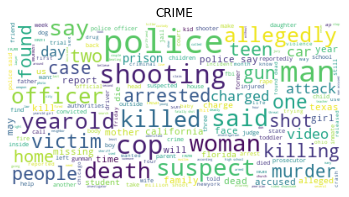

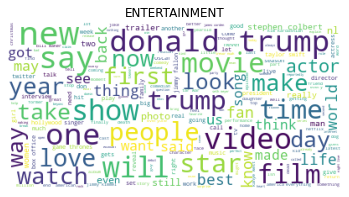

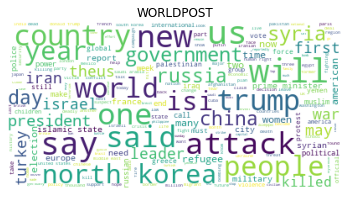

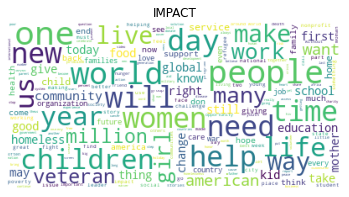

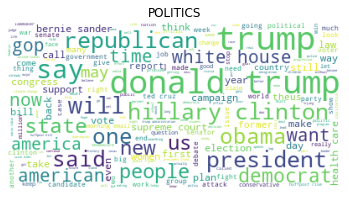

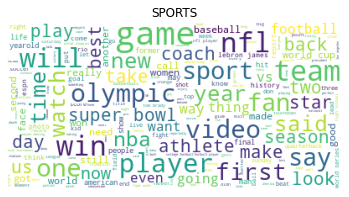

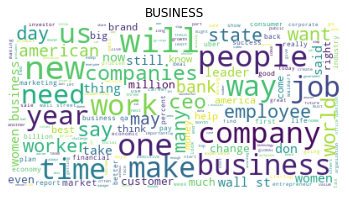

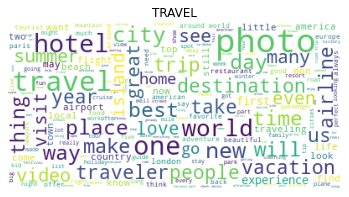

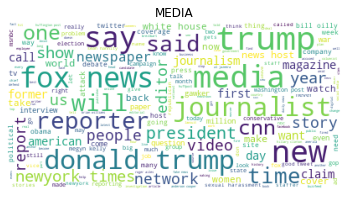

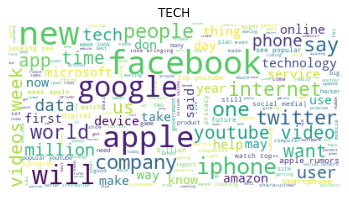

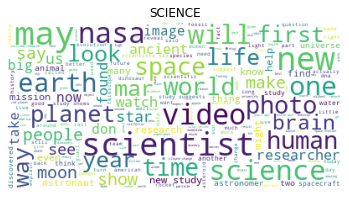

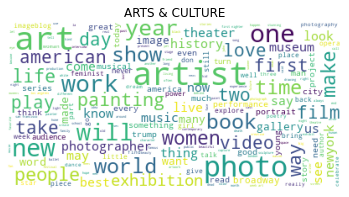

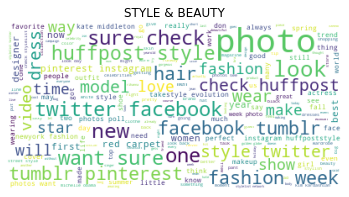

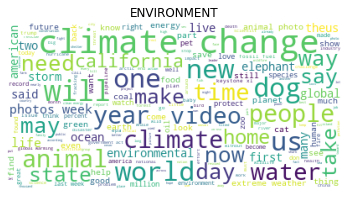

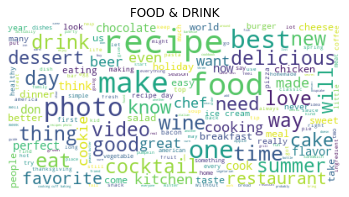

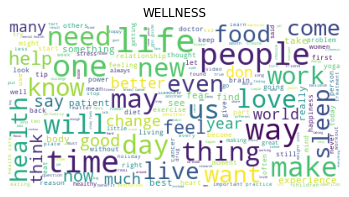

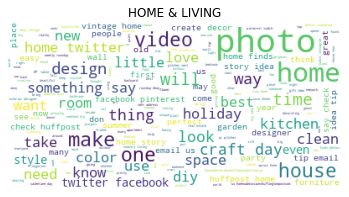

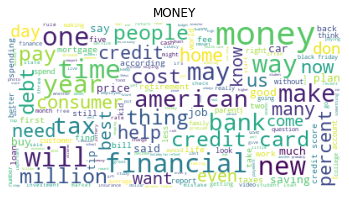

In [20]:

# generuje wordcloud dla kazdej kategorii
for x in df.category.unique():
	wc = WordCloud(background_color="white", max_words=200, stopwords=STOPWORDS,
                   max_font_size=40, random_state=42)
	wc.generate(df.text[(df.text.notnull()) & (df.category == x)].to_string())
	plt.imshow(wc)
	plt.title(x)
	plt.axis("off")
	plt.show()

# Tokenization


In [21]:
import spacy
nlp = spacy.load('en_core_web_sm')

In [22]:
all_text=df['text'].values.tolist()

In [23]:
text_nlp=list(nlp.pipe(all_text))

In [24]:
text_nlp[:5]

[there were mass shootings in texas last week but only on tv she left her husband he killed their children just another day in america,
 will smith joins diplo and nicky jam for the world cup official song of course it has a song,
 hugh grant marries for the first time at age the actor and his longtime girlfriend anna eberstein tied the knot in a civil ceremony,
 jim carrey blasts castrato adam schiff and democrats in new artwork the actor gives dems an asskicking for not fighting hard enough against donald trump,
 julianna margulies uses donald trump poop bags to pick up after her dog the dietland actress said using the bags is a really cathartic therapeutic moment]

In [25]:
text_lemma= [[word.lemma_ for word in element if not word.is_stop] for element in text_nlp]

In [26]:
text_lemma[:3]

[['mass',
  'shooting',
  'texas',
  'week',
  'tv',
  'leave',
  'husband',
  'kill',
  'child',
  'day',
  'america'],
 ['smith',
  'join',
  'diplo',
  'nicky',
  'jam',
  'world',
  'cup',
  'official',
  'song',
  'course',
  'song'],
 ['hugh',
  'grant',
  'marrie',
  'time',
  'age',
  'actor',
  'longtime',
  'girlfriend',
  'anna',
  'eberstein',
  'tie',
  'knot',
  'civil',
  'ceremony']]

In [27]:
text_lemma_joint=[' '.join(line) for line in text_lemma]
df['lemma']=pd.DataFrame(text_lemma_joint)

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155510 entries, 0 to 155509
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   category  155510 non-null  object
 1   text      155510 non-null  object
 2   lemma     155510 non-null  object
dtypes: object(3)
memory usage: 3.6+ MB


In [29]:
df.head()

category  ...                                                                                                          lemma
0          CRIME  ...                                               mass shooting texas week tv leave husband kill child day america
1  ENTERTAINMENT  ...                                                 smith join diplo nicky jam world cup official song course song
2  ENTERTAINMENT  ...                    hugh grant marrie time age actor longtime girlfriend anna eberstein tie knot civil ceremony
3  ENTERTAINMENT  ...  jim carrey blast castrato adam schiff democrats new artwork actor give dem asskicking fight hard donald trump
4  ENTERTAINMENT  ...    julianna margulies use donald trump poop bag pick dog dietland actress say bag cathartic therapeutic moment

[5 rows x 3 columns]

In [30]:
df.drop(columns=['text'], inplace=True)

In [31]:
#dzielę zbiór danych na dane treningowe i testowe
train,test= train_test_split(df, test_size = 0.3, stratify=df['category'], random_state=48)

In [32]:
train_data= pd.DataFrame(train)
test_data= pd.DataFrame(test)

In [33]:
train_data.head()

category                                                                                                                                              lemma
118151  STYLE & BEAUTY  miley cyrus vs kat graham wear versace well photo poll kat want sure check huffpost style twitt facebook tumblr pinterest instagram huffpoststyle
13467         POLITICS                           struggle gun industry look congress silencer big thing amid trump slump firearm industry seek laxer rule suppressor sale
81264     FOOD & DRINK          christmas holiday cracker beach goose fully cook bird oven let rest minute warm place kitchen sure reserve juice oven tray use rich sauce
68053        WORLDPOST                 merkel rule greek debt writeoff open relief berlin ap chancellor angela merkel sunday suggest germany flexibility negotiate greece
113769   HOME & LIVING                             silver lake california house come turret photo check huffpost home twitter facebook pinter tumblr instagram buy castle

In [34]:
train_data.to_csv('/content/drive/MyDrive/nlp/train_data_spacy.csv')
test_data.to_csv('/content/drive/MyDrive/nlp/test_data_spacy.csv')

# Vectorization

## Bag of words

In [35]:
bow =CountVectorizer(min_df=5, max_df=0.3, ngram_range=(1,2))

In [36]:
#wektoryzuje text
X_train_lemma = bow.fit_transform(train_data['lemma'])
X_test_lemma = bow.transform(test_data['lemma'])

## Tfidf

In [37]:
tfidf=TfidfVectorizer(min_df=5, max_df=0.3,ngram_range=(1,2), sublinear_tf=True)

In [38]:
#wektoryzuje text 
X_train_tfidf_lemma = tfidf.fit_transform(train_data['lemma'])
X_test_tfidf_lemma = tfidf.transform(test_data['lemma'])

In [39]:
y_train = train_data.category
y_test= test_data.category

# Classification models

In [40]:
from sklearn.svm import LinearSVC
nb_model=MultinomialNB()
lr= LogisticRegression()
sgdc_model= SGDClassifier()
svm= LinearSVC()
rfc=RandomForestClassifier()

# Naive Bayes

### Bag of words ngram range(1,2)

In [41]:
nb_model.fit(X_train_lemma,y_train)

MultinomialNB()

In [42]:
y_pred_train=nb_model.predict(X_train_lemma)
y_pred_test=nb_model.predict(X_test_lemma)

print('ACC train set: {}'.format(accuracy_score(y_train, y_pred_train)))
print('ACC test set: {}'.format(accuracy_score(y_test, y_pred_test)))
print('Mislabeled no: {}'.format((y_test != y_pred_test).sum()))

nb_lemma_train_accuracy = accuracy_score(y_train, y_pred_train)
nb_lemma_test_accuracy = accuracy_score(y_test, y_pred_test)
nb_bow_lemma_test_mislabeled = (y_test != y_pred_test).sum()

print(classification_report(y_test, y_pred_test))

ACC train set: 0.8100811155920152
ACC test set: 0.7333933509099093
Mislabeled no: 12438
                precision    recall  f1-score   support

ARTS & CULTURE       0.68      0.41      0.51      1163
      BUSINESS       0.51      0.51      0.51      1781
         CRIME       0.63      0.67      0.65      1022
 ENTERTAINMENT       0.74      0.78      0.76      6370
   ENVIRONMENT       0.57      0.50      0.53      1184
  FOOD & DRINK       0.77      0.81      0.79      2497
 HOME & LIVING       0.84      0.71      0.77      1258
        IMPACT       0.50      0.31      0.38      1038
         MEDIA       0.70      0.35      0.46       844
         MONEY       0.63      0.26      0.37       512
      POLITICS       0.79      0.83      0.81      9822
       SCIENCE       0.87      0.36      0.51       653
        SPORTS       0.81      0.69      0.74      1465
STYLE & BEAUTY       0.82      0.80      0.81      3571
          TECH       0.69      0.25      0.37       625
        TRAVEL 

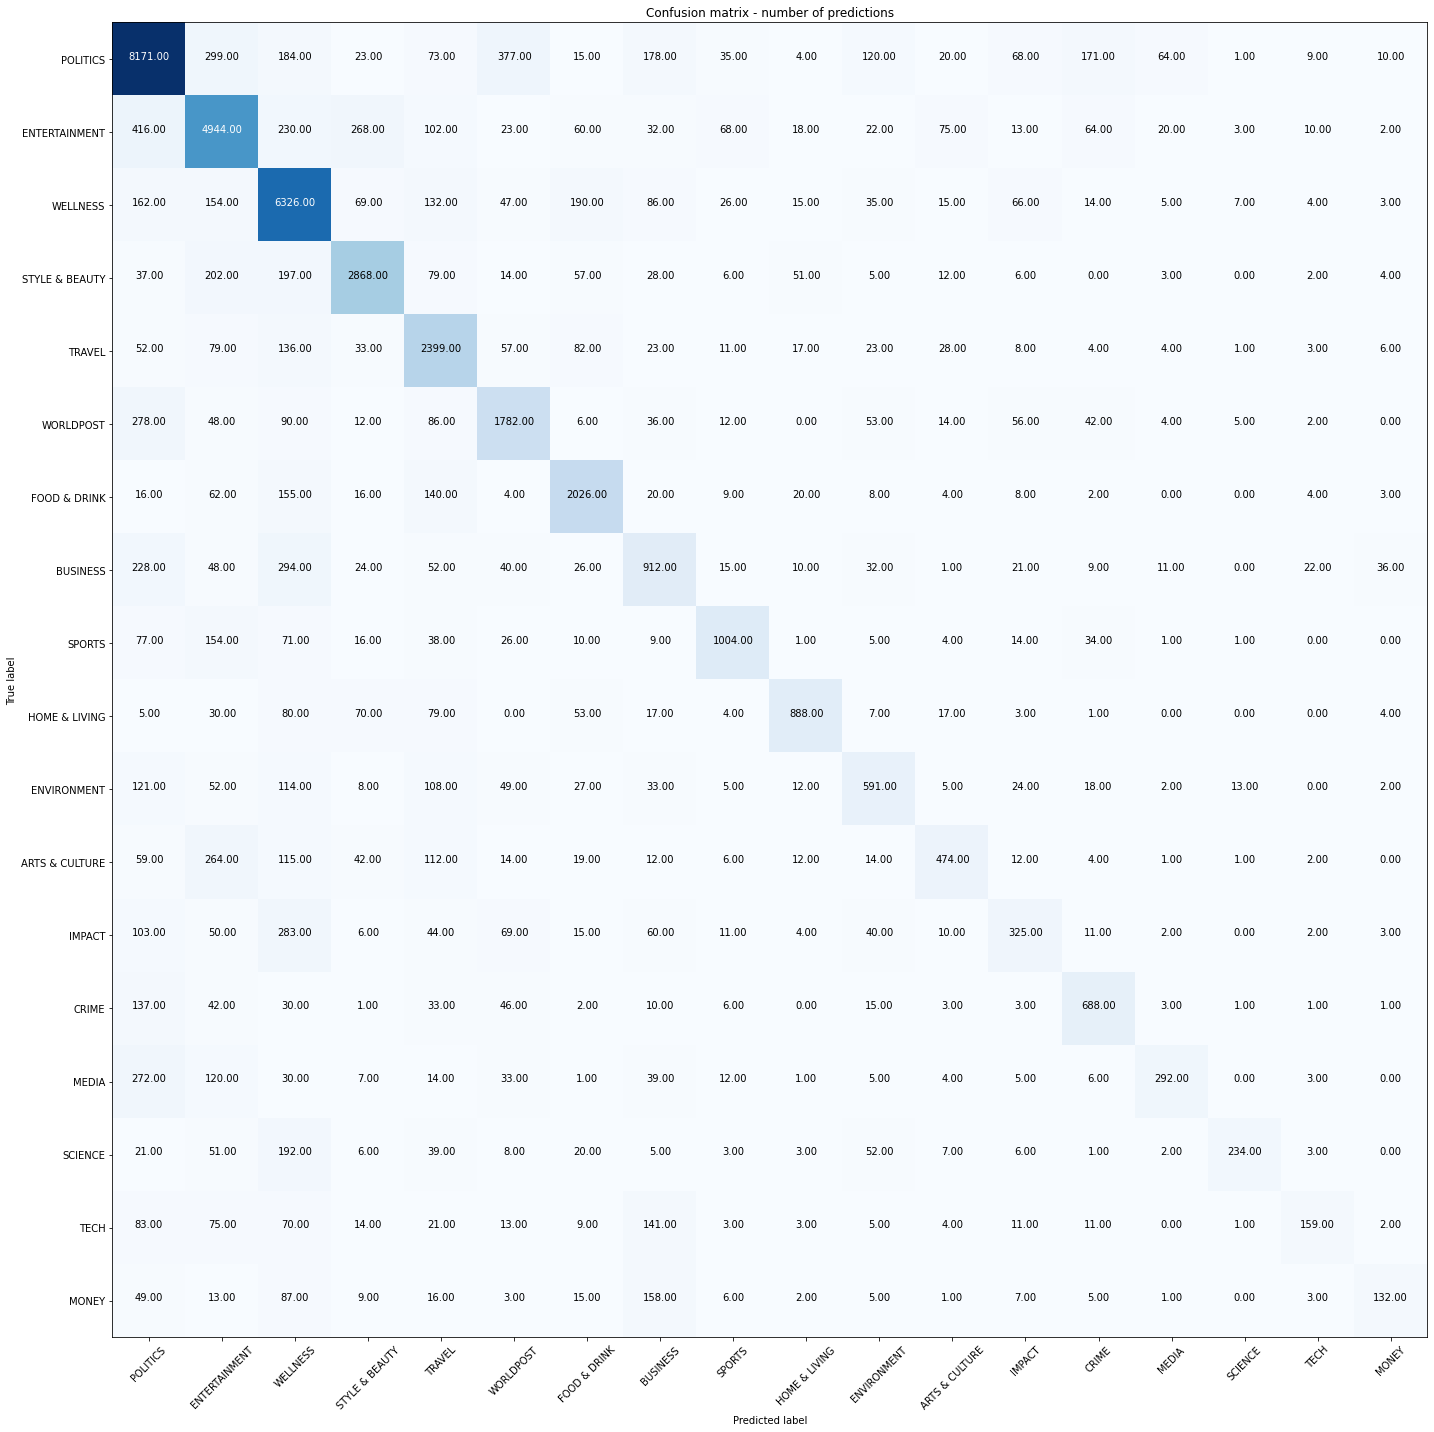

In [43]:
labels=['POLITICS','ENTERTAINMENT','WELLNESS','STYLE & BEAUTY','TRAVEL','WORLDPOST','FOOD & DRINK', 'BUSINESS','SPORTS', 'HOME & LIVING', 'ENVIRONMENT','ARTS & CULTURE','IMPACT','CRIME','MEDIA','SCIENCE','TECH','MONEY']

cm = confusion_matrix(y_test, y_pred_test, labels=labels)

cmap=plt.cm.Blues
plt.figure(figsize=(20,20))
plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.title('Confusion matrix - number of predictions')
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black"
    )
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

##Tfidf ngram range (1,2)

In [44]:
nb_model.fit(X_train_tfidf_lemma,y_train)

MultinomialNB()

In [45]:
y_pred_train=nb_model.predict(X_train_tfidf_lemma)
y_pred_test=nb_model.predict(X_test_tfidf_lemma)

print('ACC train set: {}'.format(accuracy_score(y_train, y_pred_train)))
print('ACC test set: {}'.format(accuracy_score(y_test, y_pred_test)))
print('Mislabeled no: {}'.format((y_test != y_pred_test).sum()))

nb_tfidf_lemma_train = accuracy_score(y_train, y_pred_train)
nb_tfidf_lemma_test = accuracy_score(y_test, y_pred_test)
nb_tfidf_lemma_test_mislabeled = (y_test != y_pred_test).sum()

print(classification_report(y_test, y_pred_test))

ACC train set: 0.683346041136537
ACC test set: 0.6366150086811138
Mislabeled no: 16953
                precision    recall  f1-score   support

ARTS & CULTURE       0.97      0.06      0.11      1163
      BUSINESS       0.76      0.12      0.21      1781
         CRIME       0.89      0.14      0.25      1022
 ENTERTAINMENT       0.65      0.80      0.72      6370
   ENVIRONMENT       0.87      0.09      0.16      1184
  FOOD & DRINK       0.86      0.64      0.74      2497
 HOME & LIVING       0.97      0.32      0.48      1258
        IMPACT       0.83      0.00      0.01      1038
         MEDIA       1.00      0.01      0.02       844
         MONEY       1.00      0.00      0.00       512
      POLITICS       0.57      0.95      0.71      9822
       SCIENCE       1.00      0.04      0.07       653
        SPORTS       0.91      0.28      0.43      1465
STYLE & BEAUTY       0.84      0.72      0.78      3571
          TECH       1.00      0.04      0.08       625
        TRAVEL  

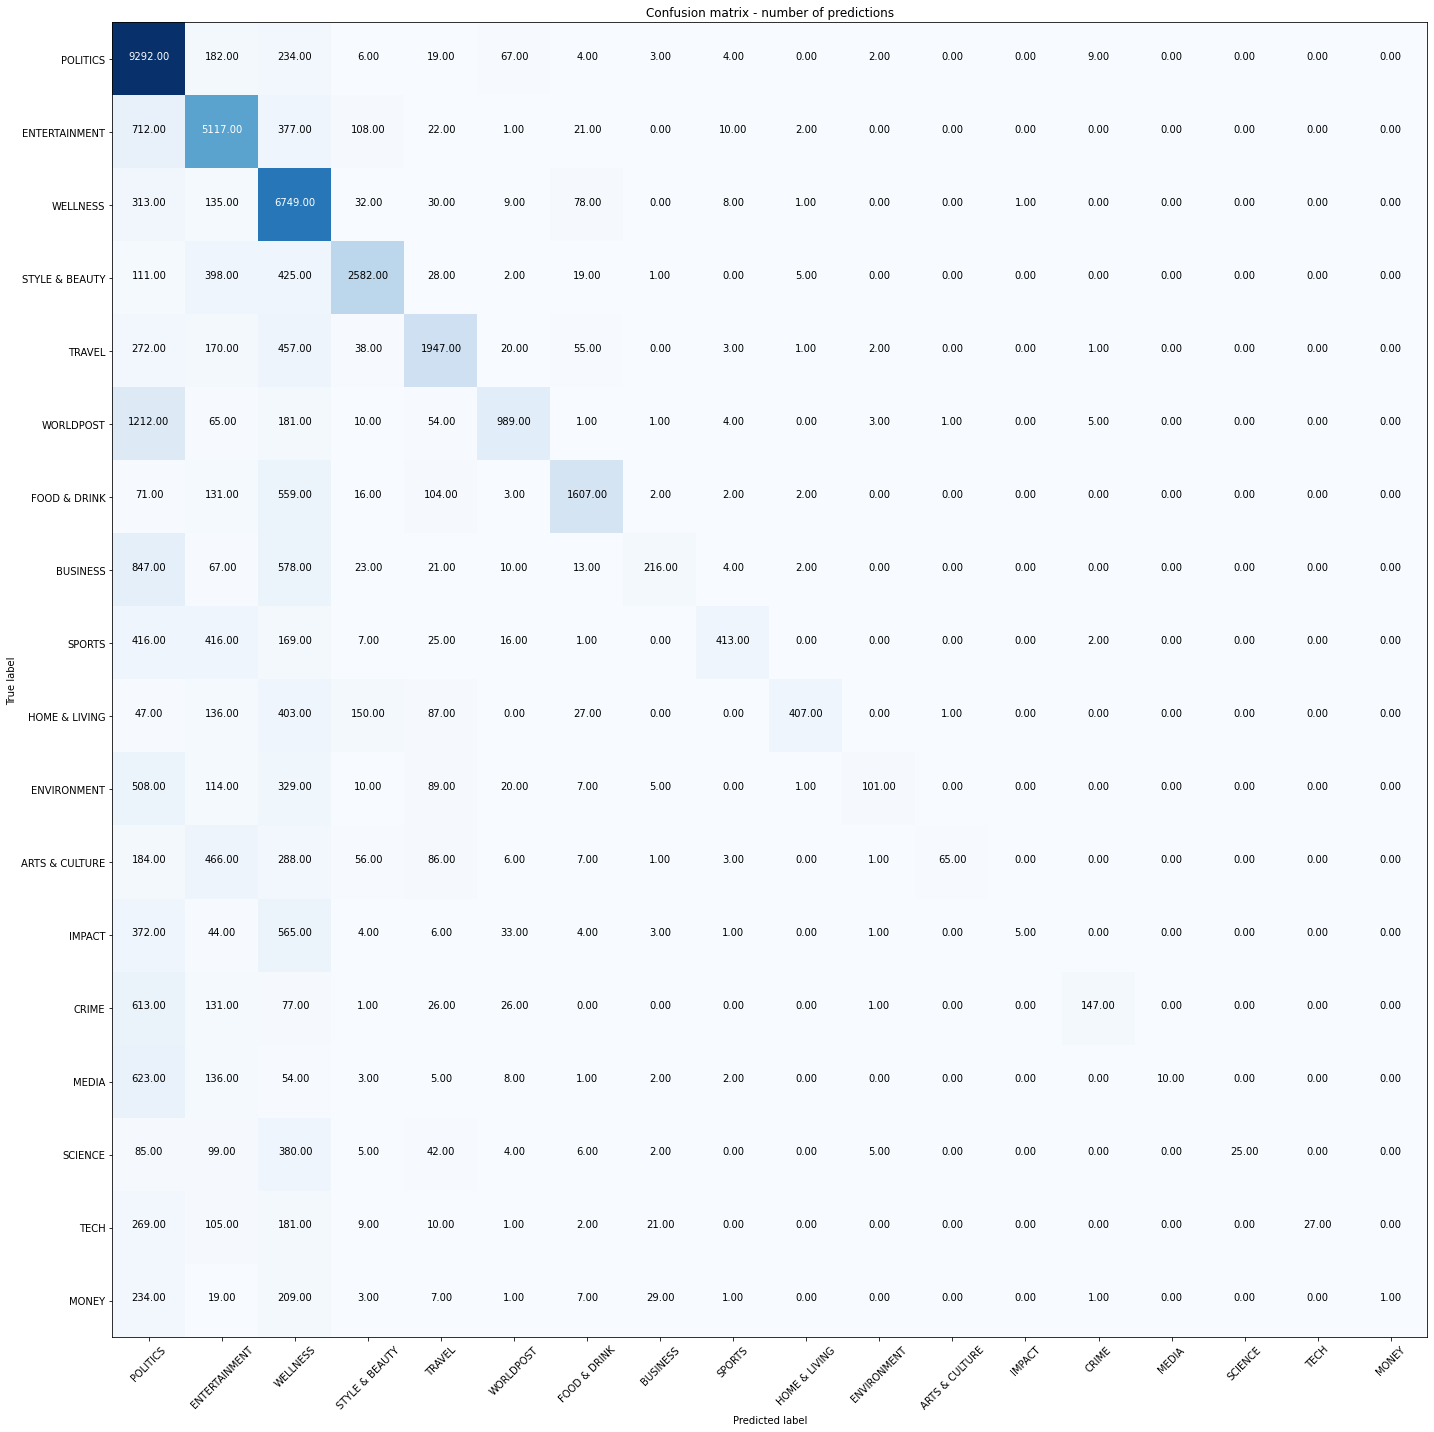

In [46]:
labels=['POLITICS','ENTERTAINMENT','WELLNESS','STYLE & BEAUTY','TRAVEL','WORLDPOST','FOOD & DRINK', 'BUSINESS','SPORTS', 'HOME & LIVING', 'ENVIRONMENT','ARTS & CULTURE','IMPACT','CRIME','MEDIA','SCIENCE','TECH','MONEY']

cm = confusion_matrix(y_test, y_pred_test, labels=labels)

cmap=plt.cm.Blues
plt.figure(figsize=(20,20))
plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.title('Confusion matrix - number of predictions')
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black"
    )
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

# Logistic regression

In [47]:
lr= LogisticRegression()

## Bag of words ngram range (1,2)

In [48]:
lr.fit(X_train_lemma,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression()

In [49]:
y_pred_train=lr.predict(X_train_lemma)
y_pred_test=lr.predict(X_test_lemma)

print('ACC train set: {}'.format(accuracy_score(y_train, y_pred_train)))
print('ACC test set: {}'.format(accuracy_score(y_test, y_pred_test)))
print('Mislabeled no: {}'.format((y_test != y_pred_test).sum()))

log_reg_bow_lemma_acc_train = accuracy_score(y_train, y_pred_train)
log_reg_bow_lemma_acc_test = accuracy_score(y_test, y_pred_test)
log_reg_bow_lemma_test_mislabeled = (y_test != y_pred_test).sum()

print(classification_report(y_test, y_pred_test))

ACC train set: 0.9651744949796522
ACC test set: 0.7330718281782522
Mislabeled no: 12453
                precision    recall  f1-score   support

ARTS & CULTURE       0.61      0.49      0.54      1163
      BUSINESS       0.53      0.47      0.50      1781
         CRIME       0.68      0.61      0.64      1022
 ENTERTAINMENT       0.71      0.81      0.76      6370
   ENVIRONMENT       0.56      0.48      0.52      1184
  FOOD & DRINK       0.79      0.77      0.78      2497
 HOME & LIVING       0.79      0.73      0.76      1258
        IMPACT       0.44      0.32      0.37      1038
         MEDIA       0.63      0.42      0.50       844
         MONEY       0.56      0.41      0.48       512
      POLITICS       0.78      0.84      0.81      9822
       SCIENCE       0.66      0.45      0.53       653
        SPORTS       0.79      0.71      0.74      1465
STYLE & BEAUTY       0.84      0.81      0.83      3571
          TECH       0.56      0.41      0.48       625
        TRAVEL 

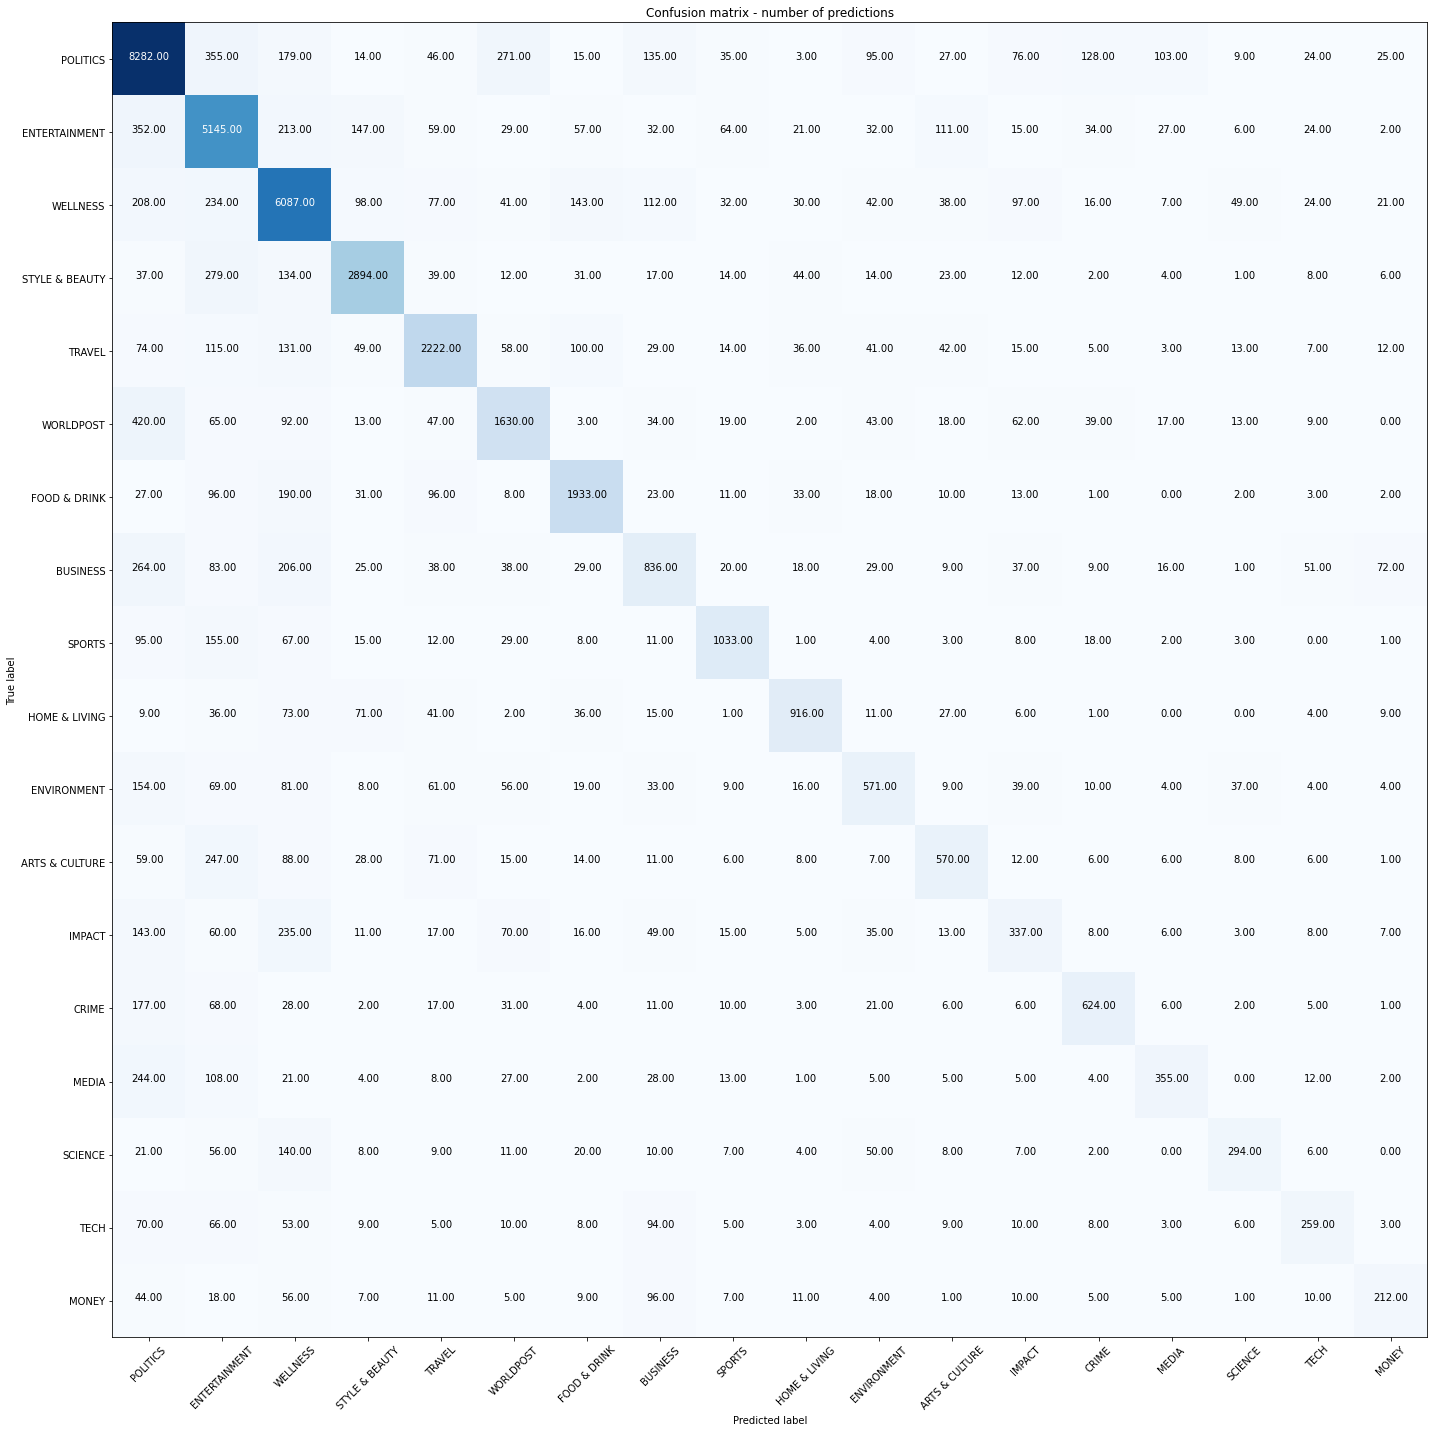

In [50]:
labels=['POLITICS','ENTERTAINMENT','WELLNESS','STYLE & BEAUTY','TRAVEL','WORLDPOST','FOOD & DRINK', 'BUSINESS','SPORTS', 'HOME & LIVING', 'ENVIRONMENT','ARTS & CULTURE','IMPACT','CRIME','MEDIA','SCIENCE','TECH','MONEY']

cm = confusion_matrix(y_test, y_pred_test, labels=labels)

cmap=plt.cm.Blues
plt.figure(figsize=(20,20))
plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.title('Confusion matrix - number of predictions')
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black"
    )
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

## Tfidf ngram range (1,2)

In [51]:
lr.fit(X_train_tfidf_lemma,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression()

In [52]:
y_pred_train=lr.predict(X_train_tfidf_lemma)
y_pred_test=lr.predict(X_test_tfidf_lemma)

print('ACC train set: {}'.format(accuracy_score(y_train, y_pred_train)))
print('ACC test set: {}'.format(accuracy_score(y_test, y_pred_test)))
print('Mislabeled no: {}'.format((y_test != y_pred_test).sum()))

log_reg_tfidf_lemma_acc_train = accuracy_score(y_train, y_pred_train)
log_reg_tfidf_lemma_acc_test = accuracy_score(y_test, y_pred_test)
log_reg_tfidf_lemma_test_mislabeled = (y_test != y_pred_test).sum()

print(classification_report(y_test, y_pred_test))

ACC train set: 0.8143344020136509
ACC test set: 0.7435105995327203
Mislabeled no: 11966
                precision    recall  f1-score   support

ARTS & CULTURE       0.70      0.43      0.53      1163
      BUSINESS       0.60      0.45      0.52      1781
         CRIME       0.74      0.58      0.65      1022
 ENTERTAINMENT       0.71      0.82      0.76      6370
   ENVIRONMENT       0.60      0.47      0.53      1184
  FOOD & DRINK       0.81      0.78      0.80      2497
 HOME & LIVING       0.83      0.71      0.77      1258
        IMPACT       0.57      0.31      0.40      1038
         MEDIA       0.69      0.35      0.47       844
         MONEY       0.66      0.32      0.43       512
      POLITICS       0.76      0.87      0.81      9822
       SCIENCE       0.80      0.41      0.54       653
        SPORTS       0.81      0.68      0.74      1465
STYLE & BEAUTY       0.82      0.81      0.82      3571
          TECH       0.59      0.40      0.47       625
        TRAVEL 

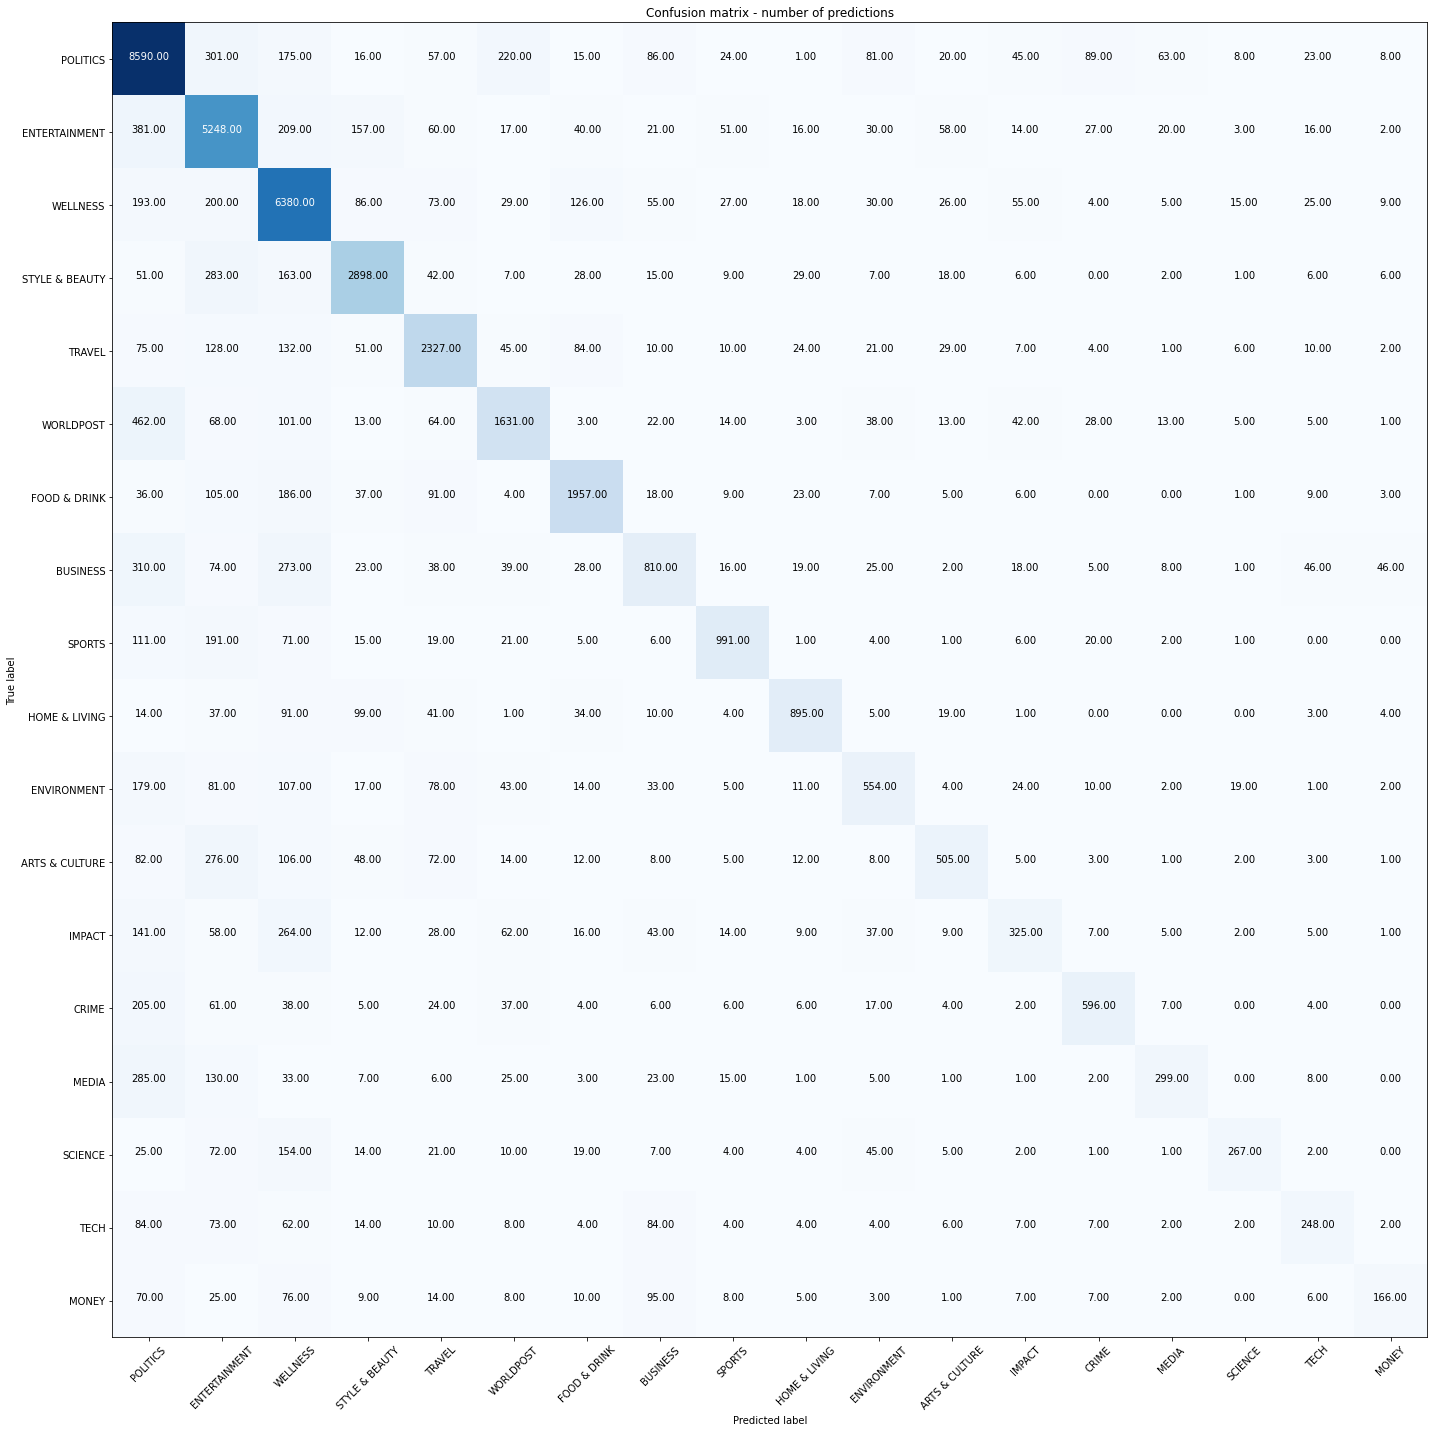

In [53]:
labels=['POLITICS','ENTERTAINMENT','WELLNESS','STYLE & BEAUTY','TRAVEL','WORLDPOST','FOOD & DRINK', 'BUSINESS','SPORTS', 'HOME & LIVING', 'ENVIRONMENT','ARTS & CULTURE','IMPACT','CRIME','MEDIA','SCIENCE','TECH','MONEY']

cm = confusion_matrix(y_test, y_pred_test, labels=labels)

cmap=plt.cm.Blues
plt.figure(figsize=(20,20))
plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.title('Confusion matrix - number of predictions')
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black"
    )
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

# Random Forest Classifier

## Bag of words ngram range (1,2)

In [54]:
rfc.fit(X_train_lemma,y_train)

RandomForestClassifier()

In [55]:
y_pred_train=rfc.predict(X_train_lemma)
y_pred_test=rfc.predict(X_test_lemma)

print('ACC train set: {}'.format(accuracy_score(y_train, y_pred_train)))
print('ACC test set: {}'.format(accuracy_score(y_test, y_pred_test)))
print('Mislabeled no: {}'.format((y_test != y_pred_test).sum()))

rfc_lemma_acc_train = accuracy_score(y_train, y_pred_train)
rfc_lemma_acc_test =  accuracy_score(y_test, y_pred_test)
rfc_lemma_test_mislabeled = (y_test != y_pred_test).sum()

print(classification_report(y_test, y_pred_test))

ACC train set: 0.9996325454495347
ACC test set: 0.6605362999164041
Mislabeled no: 15837
                precision    recall  f1-score   support

ARTS & CULTURE       0.61      0.32      0.42      1163
      BUSINESS       0.48      0.36      0.41      1781
         CRIME       0.62      0.48      0.54      1022
 ENTERTAINMENT       0.62      0.72      0.66      6370
   ENVIRONMENT       0.53      0.28      0.37      1184
  FOOD & DRINK       0.71      0.75      0.73      2497
 HOME & LIVING       0.78      0.58      0.67      1258
        IMPACT       0.57      0.07      0.12      1038
         MEDIA       0.65      0.24      0.35       844
         MONEY       0.75      0.09      0.16       512
      POLITICS       0.70      0.87      0.77      9822
       SCIENCE       0.59      0.25      0.35       653
        SPORTS       0.72      0.56      0.63      1465
STYLE & BEAUTY       0.75      0.75      0.75      3571
          TECH       0.61      0.22      0.32       625
        TRAVEL 

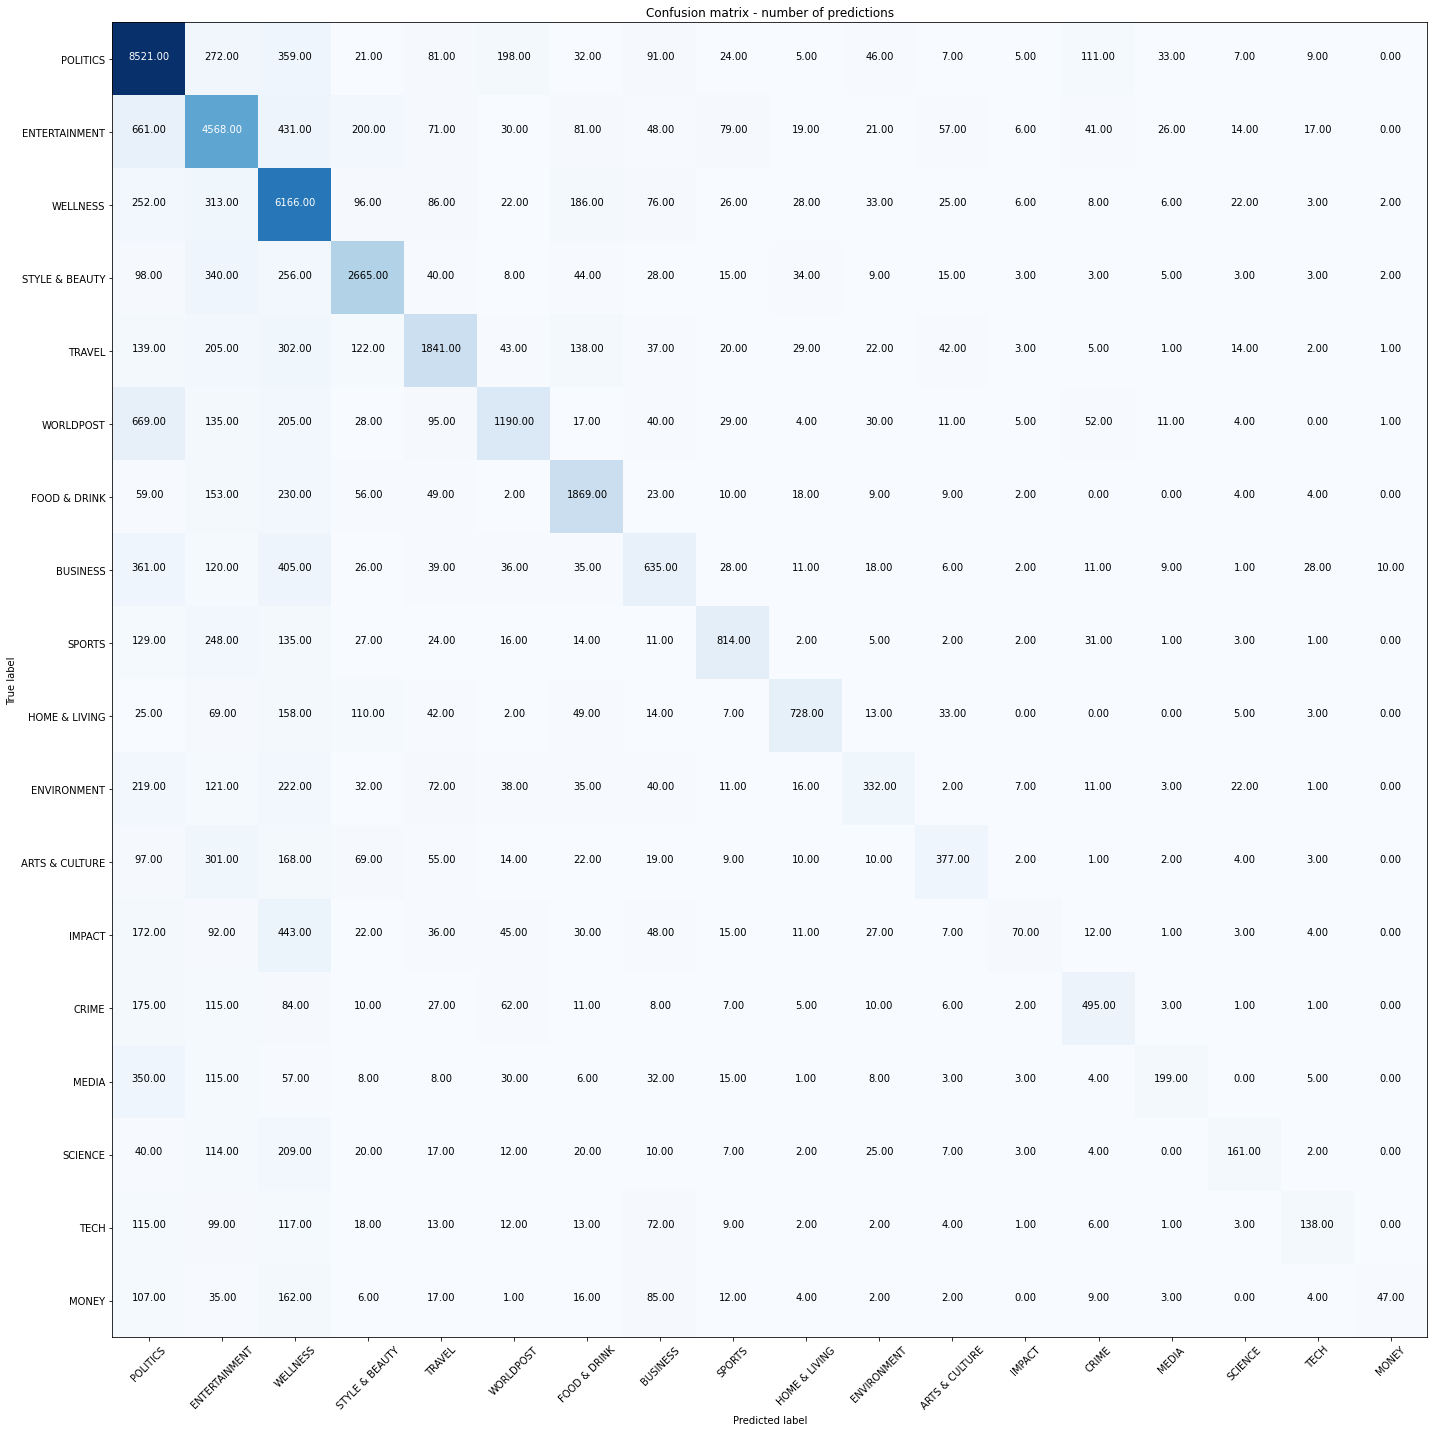

In [56]:
labels=['POLITICS','ENTERTAINMENT','WELLNESS','STYLE & BEAUTY','TRAVEL','WORLDPOST','FOOD & DRINK', 'BUSINESS','SPORTS', 'HOME & LIVING', 'ENVIRONMENT','ARTS & CULTURE','IMPACT','CRIME','MEDIA','SCIENCE','TECH','MONEY']

cm = confusion_matrix(y_test, y_pred_test, labels=labels)

cmap=plt.cm.Blues
plt.figure(figsize=(20,20))
plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.title('Confusion matrix - number of predictions')
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black"
    )
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

## Tfidf ngram range (1,2)

In [57]:
rfc.fit(X_train_tfidf_lemma,y_train)

RandomForestClassifier()

In [58]:
y_pred_train=rfc.predict(X_train_tfidf_lemma)
y_pred_test=rfc.predict(X_test_tfidf_lemma)

print('ACC train set: {}'.format(accuracy_score(y_train, y_pred_train)))
print('ACC test set: {}'.format(accuracy_score(y_test, y_pred_test)))
print('Mislabeled no: {}'.format((y_test != y_pred_test).sum()))

rfc_tfidf_lemma_acc_train = accuracy_score(y_train, y_pred_train)
rfc_tfidf_lemma_acc_test =  accuracy_score(y_test, y_pred_test)
rfc_tfidf_lemma_test_mislabeled = (y_test != y_pred_test).sum()

print(classification_report(y_test, y_pred_test))

ACC train set: 0.999623359085773
ACC test set: 0.6614579984138211
Mislabeled no: 15794
                precision    recall  f1-score   support

ARTS & CULTURE       0.63      0.32      0.43      1163
      BUSINESS       0.53      0.34      0.42      1781
         CRIME       0.64      0.49      0.56      1022
 ENTERTAINMENT       0.61      0.72      0.66      6370
   ENVIRONMENT       0.59      0.27      0.37      1184
  FOOD & DRINK       0.73      0.74      0.73      2497
 HOME & LIVING       0.79      0.56      0.65      1258
        IMPACT       0.69      0.07      0.13      1038
         MEDIA       0.64      0.20      0.31       844
         MONEY       0.66      0.12      0.20       512
      POLITICS       0.70      0.87      0.77      9822
       SCIENCE       0.67      0.24      0.35       653
        SPORTS       0.73      0.54      0.62      1465
STYLE & BEAUTY       0.75      0.75      0.75      3571
          TECH       0.62      0.25      0.36       625
        TRAVEL  

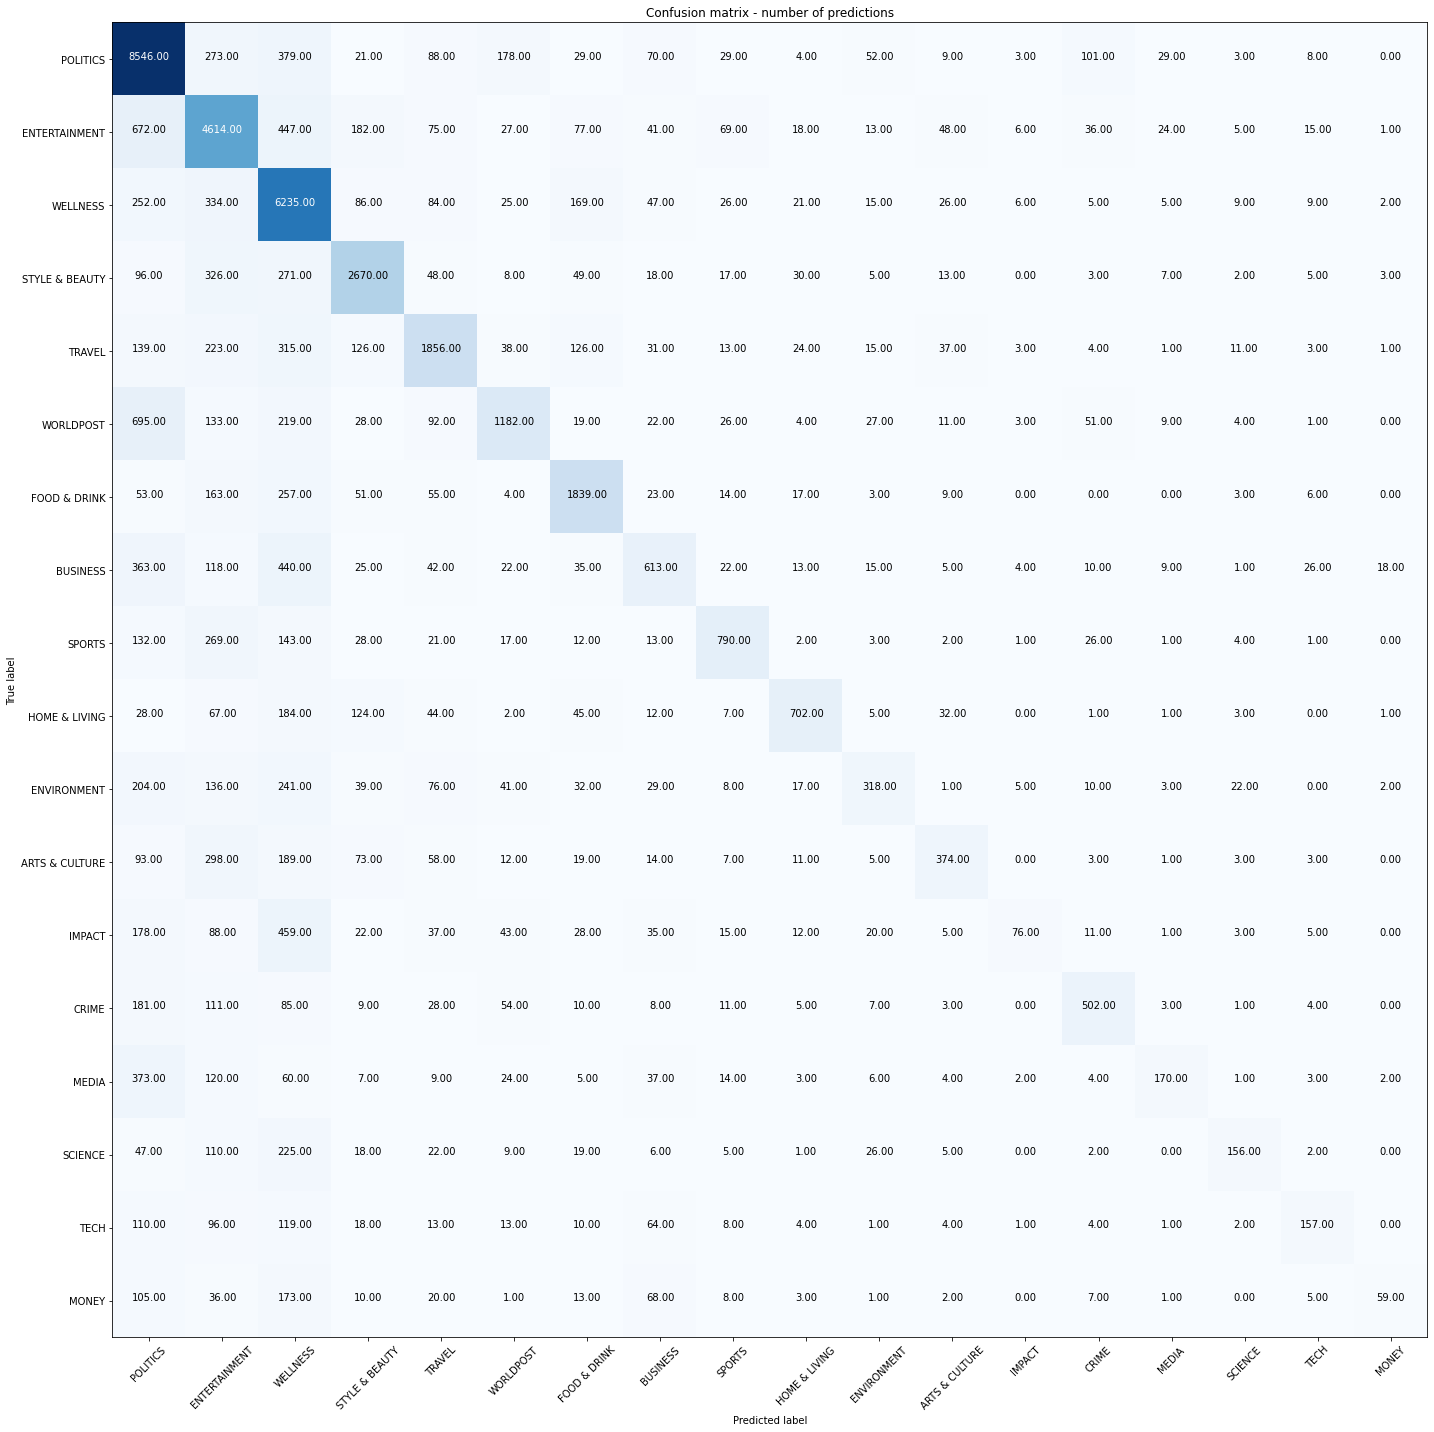

In [59]:
labels=['POLITICS','ENTERTAINMENT','WELLNESS','STYLE & BEAUTY','TRAVEL','WORLDPOST','FOOD & DRINK', 'BUSINESS','SPORTS', 'HOME & LIVING', 'ENVIRONMENT','ARTS & CULTURE','IMPACT','CRIME','MEDIA','SCIENCE','TECH','MONEY']

cm = confusion_matrix(y_test, y_pred_test, labels=labels)

cmap=plt.cm.Blues
plt.figure(figsize=(20,20))
plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.title('Confusion matrix - number of predictions')
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black"
    )
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

# SGDClassifier

In [60]:
sgdc_model=SGDClassifier()

## Bag of words ngram range (1,2)

In [61]:
sgdc_model.fit(X_train_lemma,y_train)

SGDClassifier()

In [62]:
y_pred_train=sgdc_model.predict(X_train_lemma)
y_pred_test=sgdc_model.predict(X_test_lemma)

print('ACC train set: {}'.format(accuracy_score(y_train, y_pred_train)))
print('ACC test set: {}'.format(accuracy_score(y_test, y_pred_test)))
print('Mislabeled no: {}'.format((y_test != y_pred_test).sum()))

sgdc_bow_lemma_train_acc = accuracy_score(y_train, y_pred_train)
sgdc_bow_lemma_test_acc = accuracy_score(y_test, y_pred_test)
sgdc_bow_lemma_test_mislabeled = (y_test != y_pred_test).sum()

print(classification_report(y_test, y_pred_test))

ACC train set: 0.87950246653867
ACC test set: 0.7427603798255203
Mislabeled no: 12001
                precision    recall  f1-score   support

ARTS & CULTURE       0.63      0.50      0.56      1163
      BUSINESS       0.58      0.44      0.50      1781
         CRIME       0.70      0.59      0.64      1022
 ENTERTAINMENT       0.73      0.80      0.77      6370
   ENVIRONMENT       0.59      0.45      0.51      1184
  FOOD & DRINK       0.76      0.82      0.79      2497
 HOME & LIVING       0.80      0.72      0.76      1258
        IMPACT       0.56      0.29      0.38      1038
         MEDIA       0.63      0.39      0.48       844
         MONEY       0.61      0.40      0.48       512
      POLITICS       0.76      0.88      0.82      9822
       SCIENCE       0.73      0.43      0.54       653
        SPORTS       0.75      0.73      0.74      1465
STYLE & BEAUTY       0.84      0.81      0.82      3571
          TECH       0.60      0.38      0.47       625
        TRAVEL   

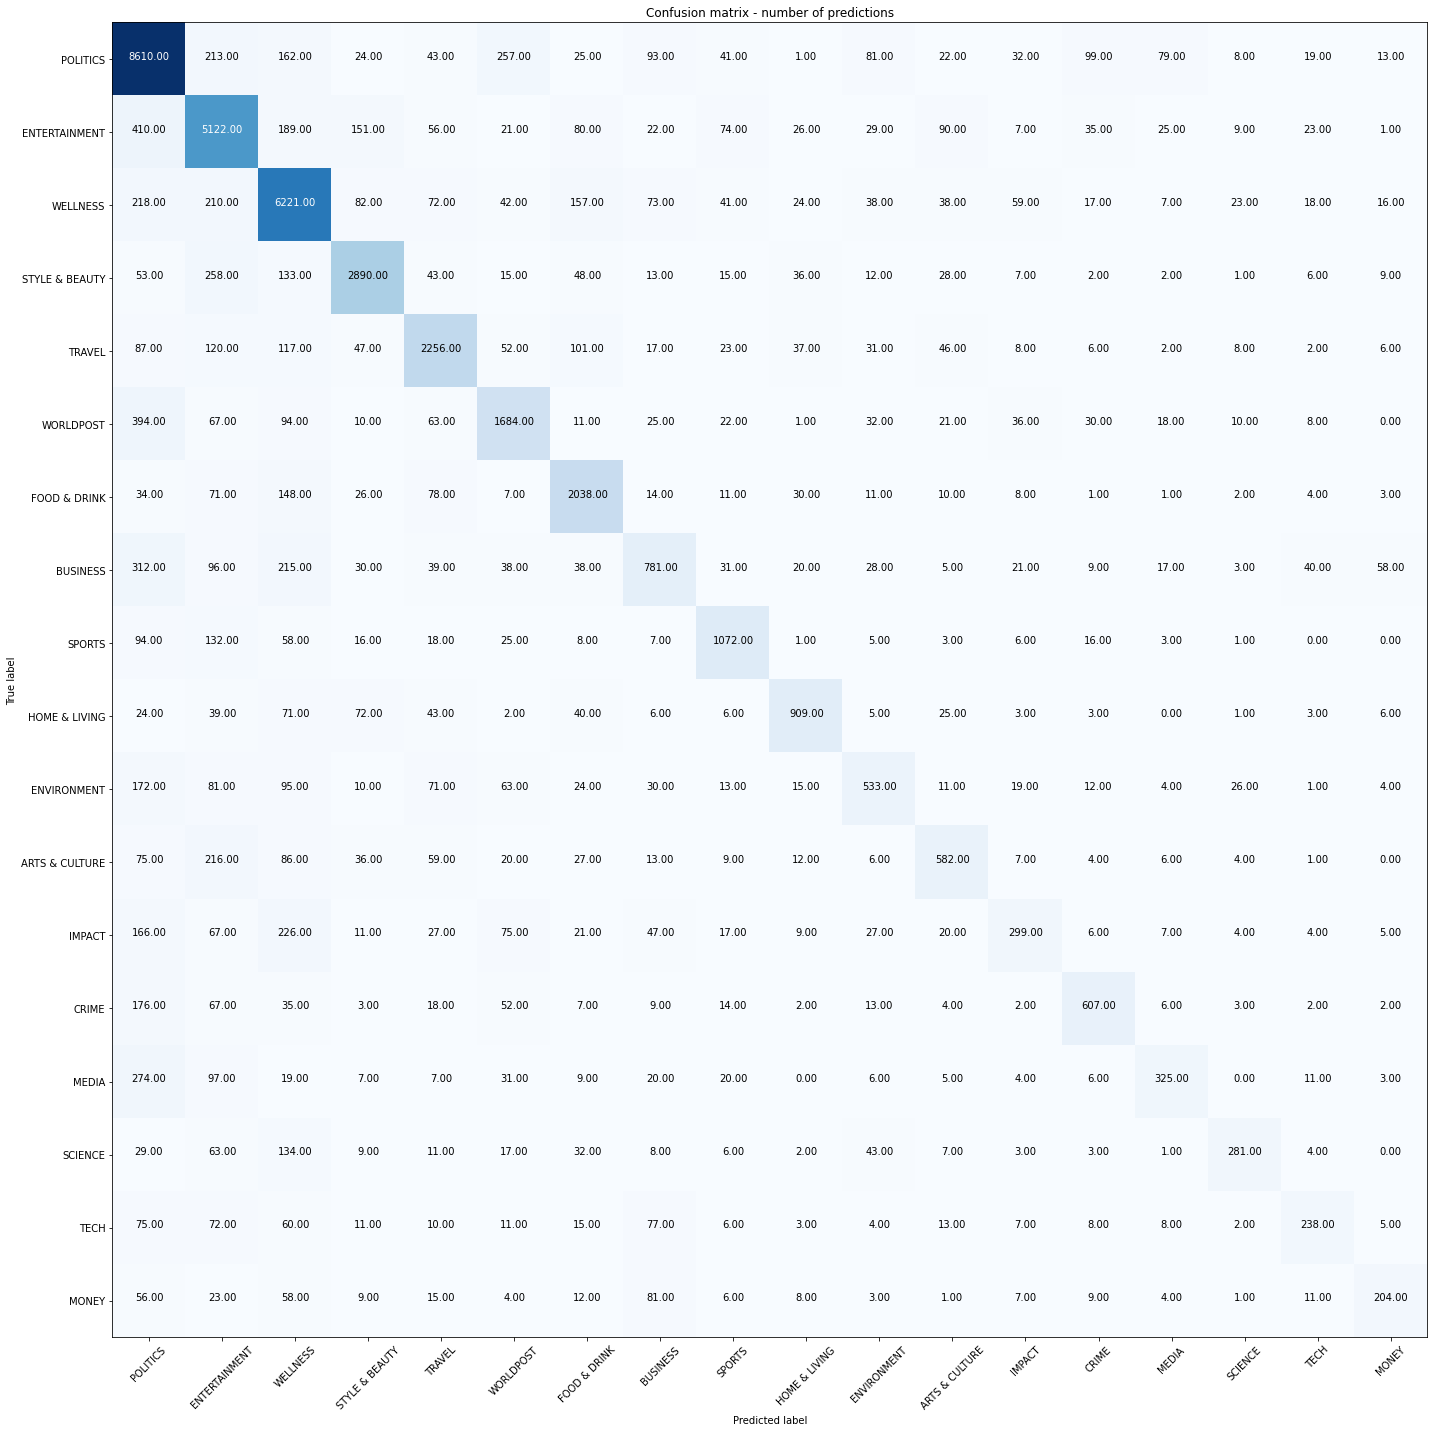

In [63]:
labels=['POLITICS','ENTERTAINMENT','WELLNESS','STYLE & BEAUTY','TRAVEL','WORLDPOST','FOOD & DRINK', 'BUSINESS','SPORTS', 'HOME & LIVING', 'ENVIRONMENT','ARTS & CULTURE','IMPACT','CRIME','MEDIA','SCIENCE','TECH','MONEY']

cm = confusion_matrix(y_test, y_pred_test, labels=labels)

cmap=plt.cm.Blues
plt.figure(figsize=(20,20))
plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.title('Confusion matrix - number of predictions')
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black"
    )
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

## Tfidf ngram range(1,2)

In [64]:
sgdc_model.fit(X_train_tfidf_lemma,y_train)

SGDClassifier()

In [65]:
y_pred_train=sgdc_model.predict(X_train_tfidf_lemma)
y_pred_test=sgdc_model.predict(X_test_tfidf_lemma)

print('ACC train set: {}'.format(accuracy_score(y_train, y_pred_train)))
print('ACC test set: {}'.format(accuracy_score(y_test, y_pred_test)))
print('Mislabeled no: {}'.format((y_test != y_pred_test).sum()))

sgdc_tfidf_lemma_train_acc = accuracy_score(y_train, y_pred_train)
sgdc_tfidf_lemma_test_acc = accuracy_score(y_test, y_pred_test)
sgdc_tfidf_lemma_test_mislabeled = (y_test != y_pred_test).sum()

print(classification_report(y_test, y_pred_test))

ACC train set: 0.782485278852072
ACC test set: 0.7226759265213384
Mislabeled no: 12938
                precision    recall  f1-score   support

ARTS & CULTURE       0.72      0.36      0.48      1163
      BUSINESS       0.67      0.34      0.45      1781
         CRIME       0.69      0.52      0.60      1022
 ENTERTAINMENT       0.74      0.77      0.75      6370
   ENVIRONMENT       0.65      0.33      0.44      1184
  FOOD & DRINK       0.77      0.81      0.79      2497
 HOME & LIVING       0.78      0.68      0.73      1258
        IMPACT       0.62      0.13      0.22      1038
         MEDIA       0.73      0.26      0.38       844
         MONEY       0.67      0.26      0.37       512
      POLITICS       0.72      0.90      0.80      9822
       SCIENCE       0.76      0.32      0.45       653
        SPORTS       0.78      0.69      0.73      1465
STYLE & BEAUTY       0.78      0.82      0.80      3571
          TECH       0.60      0.33      0.42       625
        TRAVEL  

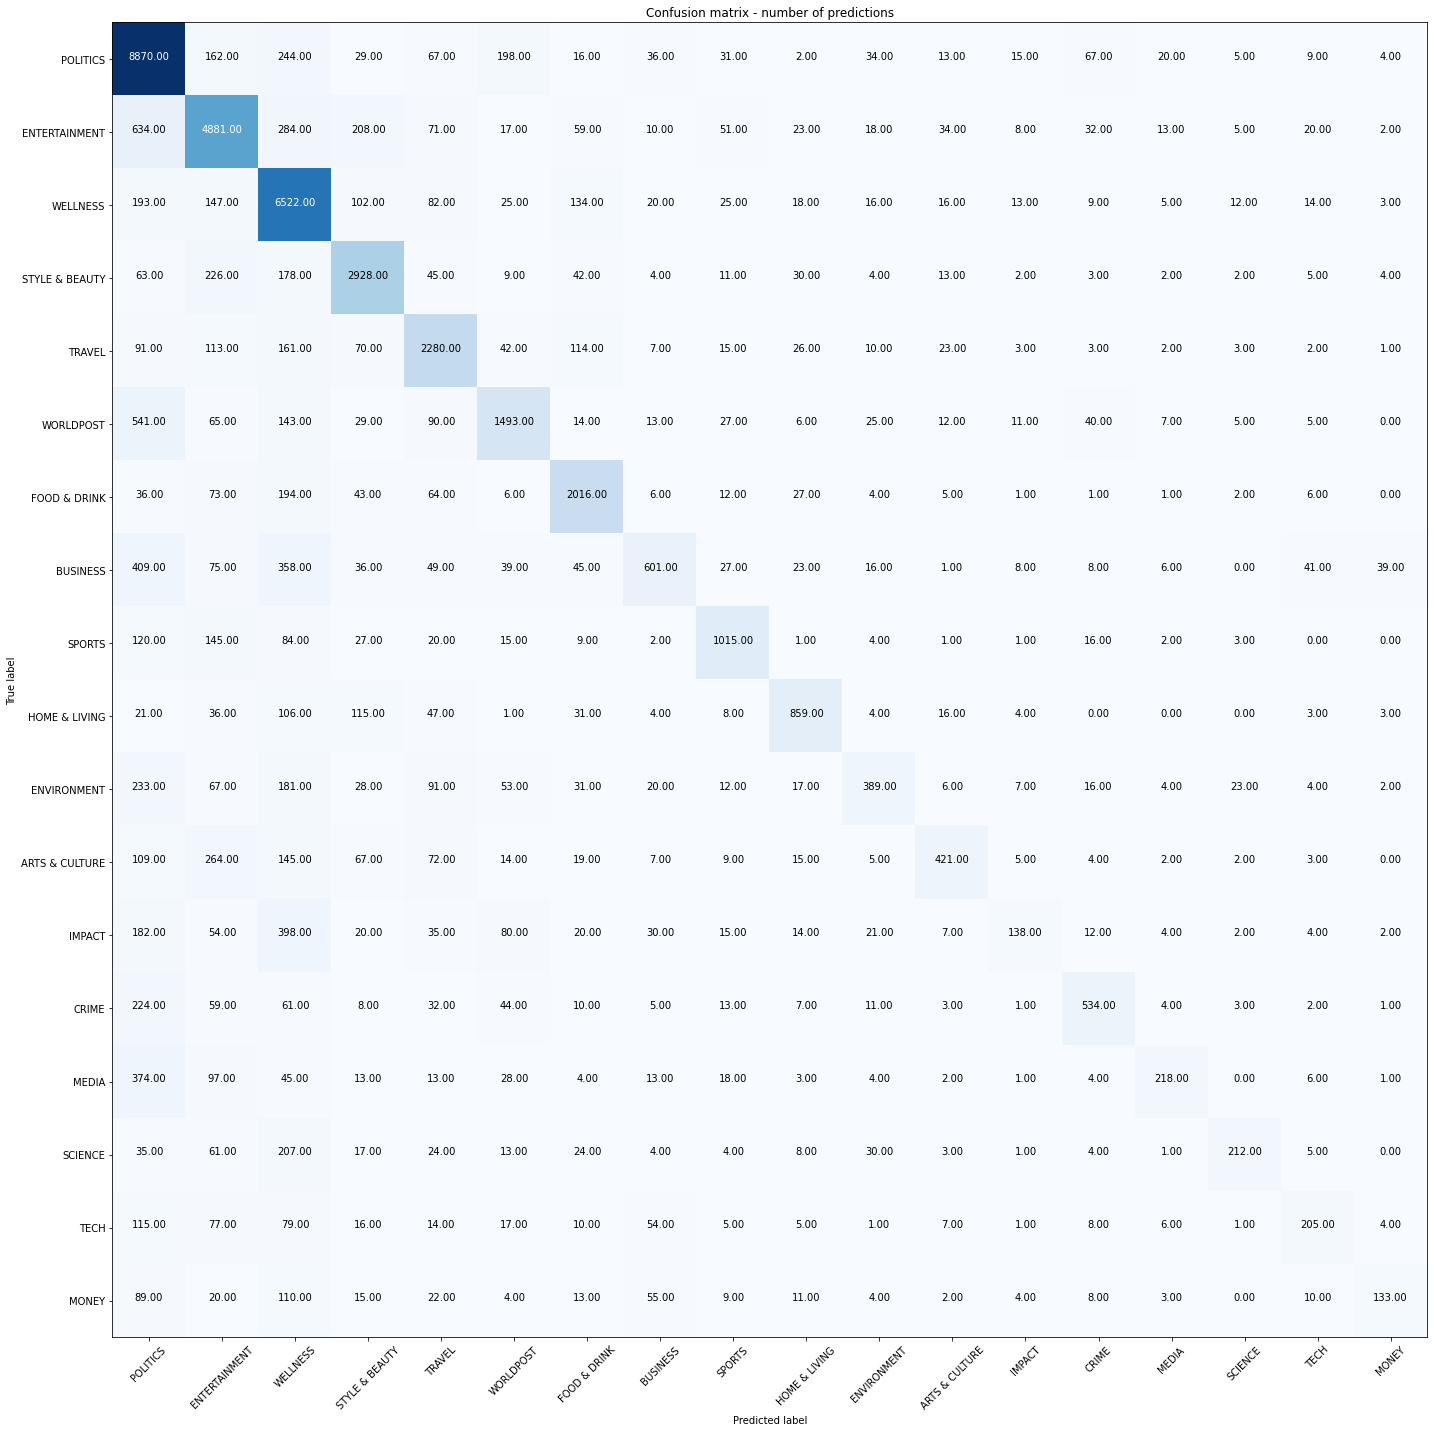

In [66]:
labels=['POLITICS','ENTERTAINMENT','WELLNESS','STYLE & BEAUTY','TRAVEL','WORLDPOST','FOOD & DRINK', 'BUSINESS','SPORTS', 'HOME & LIVING', 'ENVIRONMENT','ARTS & CULTURE','IMPACT','CRIME','MEDIA','SCIENCE','TECH','MONEY']

cm = confusion_matrix(y_test, y_pred_test, labels=labels)

cmap=plt.cm.Blues
plt.figure(figsize=(20,20))
plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.title('Confusion matrix - number of predictions')
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black"
    )
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

# Linear SVC

## Bag of words ngram range (1,2)

In [67]:
svm = LinearSVC()
svm.fit(X_train_lemma,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


LinearSVC()

In [68]:
y_pred_train=svm.predict(X_train_lemma)
y_pred_test=svm.predict(X_test_lemma)

print('ACC train set: {}'.format(accuracy_score(y_train, y_pred_train)))
print('ACC test set: {}'.format(accuracy_score(y_test, y_pred_test)))
print('Mislabeled no: {}'.format((y_test != y_pred_test).sum()))

svm_bow_train_acc = accuracy_score(y_train, y_pred_train)
svm_bow_test_acc = accuracy_score(y_test, y_pred_test)
svm_lemma_bow_test_mislabeled = (y_test != y_pred_test).sum()

print(classification_report(y_test, y_pred_test))

ACC train set: 0.9948740090210092
ACC test set: 0.7015840353246308
Mislabeled no: 13922
                precision    recall  f1-score   support

ARTS & CULTURE       0.53      0.47      0.49      1163
      BUSINESS       0.46      0.42      0.44      1781
         CRIME       0.62      0.59      0.61      1022
 ENTERTAINMENT       0.72      0.76      0.74      6370
   ENVIRONMENT       0.49      0.46      0.48      1184
  FOOD & DRINK       0.75      0.75      0.75      2497
 HOME & LIVING       0.74      0.71      0.73      1258
        IMPACT       0.34      0.30      0.32      1038
         MEDIA       0.50      0.44      0.47       844
         MONEY       0.44      0.35      0.39       512
      POLITICS       0.77      0.81      0.79      9822
       SCIENCE       0.52      0.46      0.48       653
        SPORTS       0.72      0.70      0.71      1465
STYLE & BEAUTY       0.81      0.80      0.80      3571
          TECH       0.46      0.40      0.43       625
        TRAVEL 

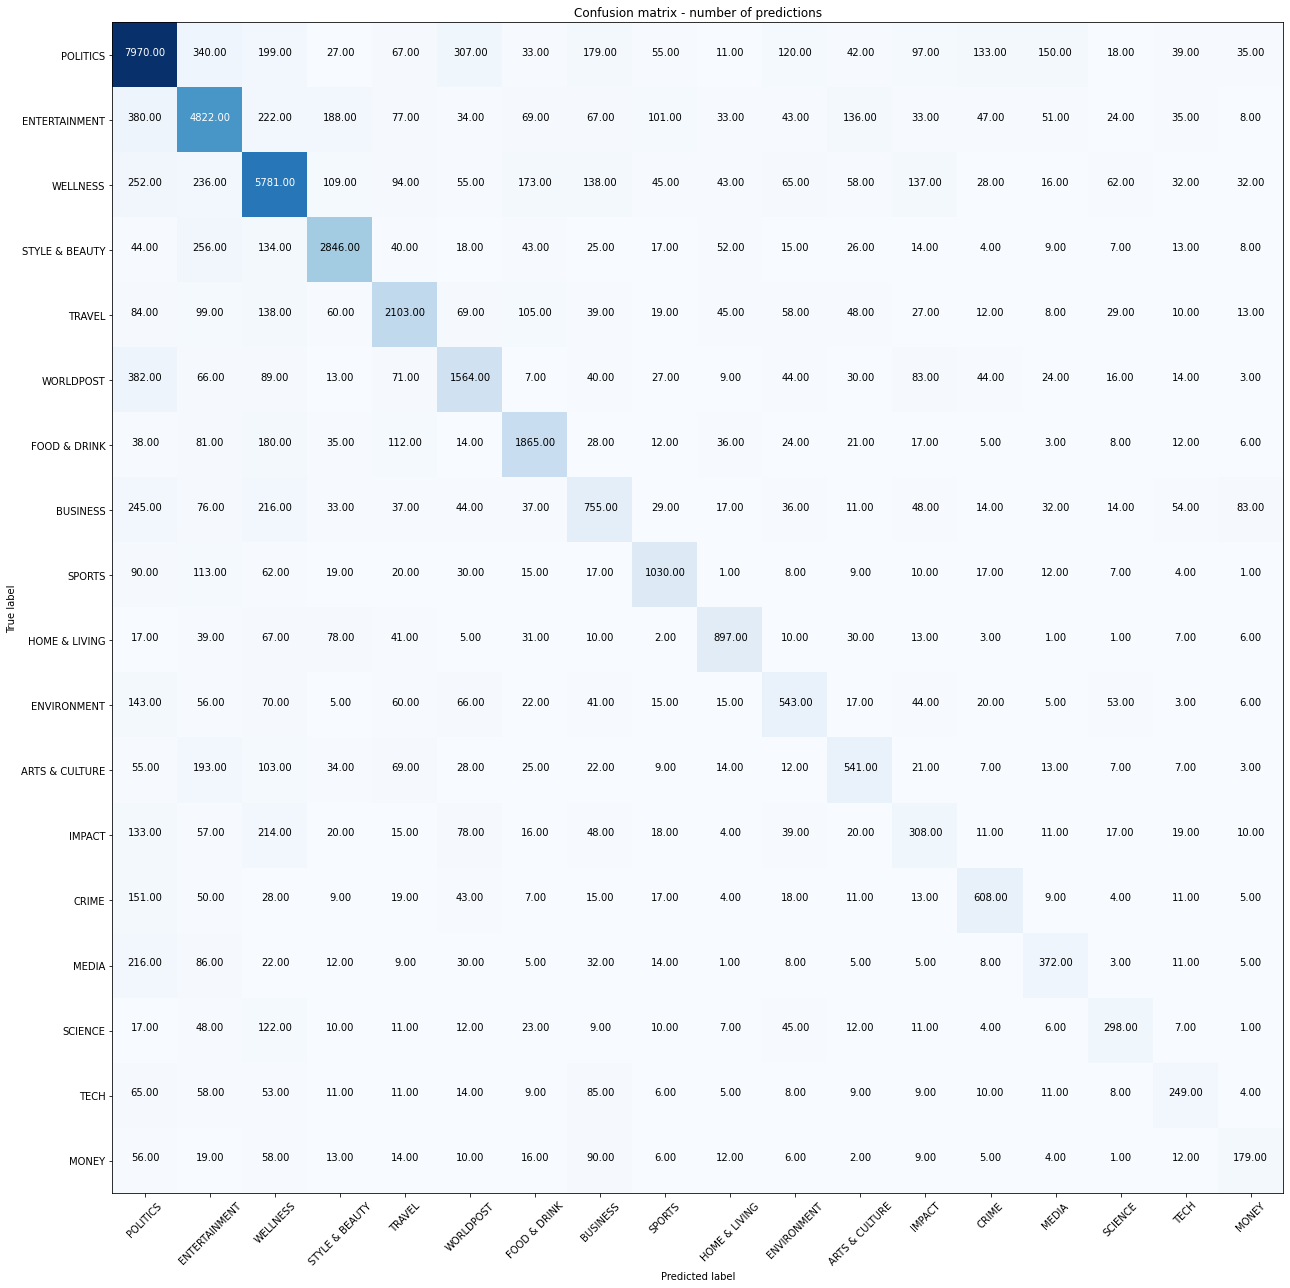

In [69]:
labels=['POLITICS','ENTERTAINMENT','WELLNESS','STYLE & BEAUTY','TRAVEL','WORLDPOST','FOOD & DRINK', 'BUSINESS','SPORTS', 'HOME & LIVING', 'ENVIRONMENT','ARTS & CULTURE','IMPACT','CRIME','MEDIA','SCIENCE','TECH','MONEY']

cm = confusion_matrix(y_test, y_pred_test, labels=labels)

cmap=plt.cm.Blues
plt.figure(figsize=(18,18))
plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.title('Confusion matrix - number of predictions')
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black"
    )
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

## Tfidf ngram range (1,2)

In [70]:
svm.fit(X_train_tfidf_lemma,y_train)

LinearSVC()

In [71]:
y_pred_train=svm.predict(X_train_tfidf_lemma)
y_pred_test=svm.predict(X_test_tfidf_lemma)

print('ACC train set: {}'.format(accuracy_score(y_train, y_pred_train)))
print('ACC test set: {}'.format(accuracy_score(y_test, y_pred_test)))
print('Mislabeled no: {}'.format((y_test != y_pred_test).sum()))

svm_tfidf_train_acc = accuracy_score(y_train, y_pred_train)
svm_tfidf_test_acc = accuracy_score(y_test, y_pred_test)
svm_lemma_tfidf_test_mislabeled = (y_test != y_pred_test).sum()

print(classification_report(y_test, y_pred_test))

ACC train set: 0.9603057221859871
ACC test set: 0.7479476132295887
Mislabeled no: 11759
                precision    recall  f1-score   support

ARTS & CULTURE       0.64      0.51      0.57      1163
      BUSINESS       0.56      0.47      0.51      1781
         CRIME       0.70      0.63      0.66      1022
 ENTERTAINMENT       0.76      0.80      0.78      6370
   ENVIRONMENT       0.57      0.50      0.53      1184
  FOOD & DRINK       0.79      0.80      0.80      2497
 HOME & LIVING       0.80      0.75      0.78      1258
        IMPACT       0.47      0.32      0.38      1038
         MEDIA       0.62      0.44      0.51       844
         MONEY       0.54      0.41      0.47       512
      POLITICS       0.79      0.86      0.82      9822
       SCIENCE       0.66      0.46      0.55       653
        SPORTS       0.79      0.75      0.77      1465
STYLE & BEAUTY       0.84      0.83      0.83      3571
          TECH       0.58      0.42      0.49       625
        TRAVEL 

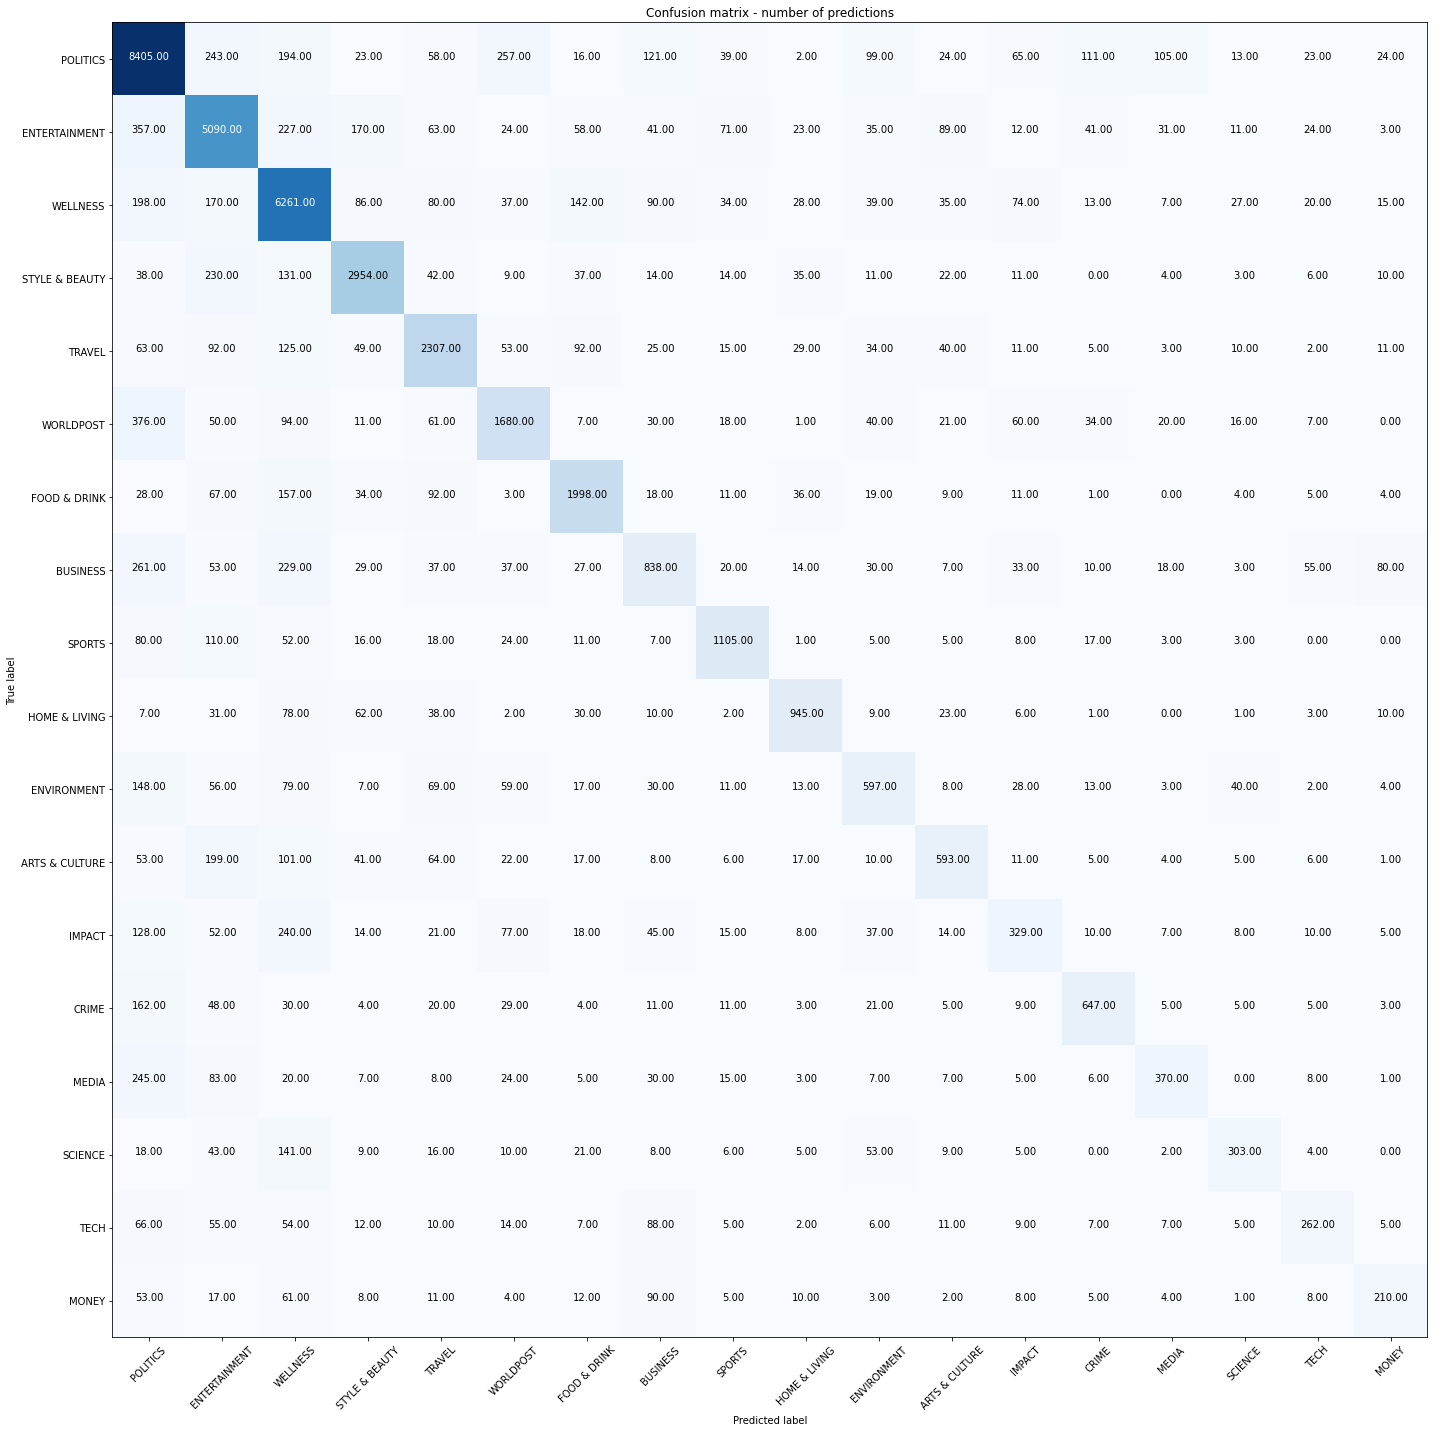

In [72]:
labels=['POLITICS','ENTERTAINMENT','WELLNESS','STYLE & BEAUTY','TRAVEL','WORLDPOST','FOOD & DRINK', 'BUSINESS','SPORTS', 'HOME & LIVING', 'ENVIRONMENT','ARTS & CULTURE','IMPACT','CRIME','MEDIA','SCIENCE','TECH','MONEY']

cm = confusion_matrix(y_test, y_pred_test, labels=labels)

cmap=plt.cm.Blues
plt.figure(figsize=(20,20))
plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.title('Confusion matrix - number of predictions')
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black"
    )
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

# Removing "Donald Trump" 

In [73]:
from sklearn.feature_extraction import text

In [74]:
my_stop_words=text.ENGLISH_STOP_WORDS.union(['donald','trump','donald trump'])

In [ ]:
#my_stop_words

In [75]:
tfidf=TfidfVectorizer(min_df=5, max_df=0.3,stop_words=my_stop_words, sublinear_tf=True)

In [76]:
#wektoryzuje text
X_train_notrump = tfidf.fit_transform(train_data['lemma'])
X_test_notrump = tfidf.transform(test_data['lemma'])

y_train = train_data.category
y_test= test_data.category

In [77]:
svm.fit(X_train_notrump,y_train)

LinearSVC()

In [79]:
y_pred_train=svm.predict(X_train_notrump)
y_pred_test=svm.predict(X_test_notrump)

print('ACC train set: {}'.format(accuracy_score(y_train, y_pred_train)))
print('ACC test set: {}'.format(accuracy_score(y_test, y_pred_test)))
print('Mislabeled no: {}'.format((y_test != y_pred_test).sum()))

swm_notrump_train_accuracy = accuracy_score(y_train, y_pred_train)
svm_notrump_test_accuracy = accuracy_score(y_test, y_pred_test)


ACC train set: 0.9026796623092681
ACC test set: 0.7329217842368122
Mislabeled no: 12460


# Results per model and vectorization type

In [81]:

print('MultinomialNB BOW ngram (1,2) accuracy')
print(f'dla train {nb_lemma_train_accuracy}')
print(f'dla test  {nb_lemma_test_accuracy}')
print(f'Mislabeled no: {nb_bow_lemma_test_mislabeled}')
print('-'*50)


print('MultinomialNB TFIDF ngram (1,2) accuracy')
print(f'dla train {nb_tfidf_lemma_train}')
print(f'dla test  {nb_tfidf_lemma_test}')
print(f'Mislabeled no: {nb_tfidf_lemma_test_mislabeled}')
print('-'*50)


print('Logistic Regression BOW ngram(1,2) accuracy')
print(f'dla train {log_reg_bow_lemma_acc_train}')
print(f'dla test  {log_reg_bow_lemma_acc_test}')
print(f'Mislabeled no: {log_reg_bow_lemma_test_mislabeled}')
print('-'*50)

print('Logistic Regression TFIDF ngram(1,2) accuracy')
print(f'dla train {log_reg_tfidf_lemma_acc_train}')
print(f'dla test  {log_reg_tfidf_lemma_acc_test}')
print(f'Mislabeled no: {log_reg_tfidf_lemma_test_mislabeled}')
print('-'*50)


print('Random Forest Classifier BOW ngram(1,2) accuracy')
print(f'dla train {rfc_lemma_acc_train}')
print(f'dla test  {rfc_lemma_acc_test}')
print(f'Mislabeled no: {rfc_lemma_test_mislabeled}')
print('-'*50)

print('Random Forest Classifier TFIDF ngram(1,2) accuracy')
print(f'dla train {rfc_tfidf_lemma_acc_train}')
print(f'dla test {rfc_tfidf_lemma_acc_test}')
print(f'Mislabeled no: {rfc_tfidf_lemma_test_mislabeled}')
print('-'*50)

print('SGDClassifier BOW ngram(1,2) accuracy')
print(f'dla train {sgdc_bow_lemma_train_acc}')
print(f'dla test  {sgdc_bow_lemma_test_acc}')
print(f'Mislabeled no: {sgdc_bow_lemma_test_mislabeled}')
print('-'*50)

print('SGDClassifier TFIDF ngram(1,2) accuracy')
print(f'dla train {sgdc_tfidf_lemma_train_acc}')
print(f'dla test  {sgdc_tfidf_lemma_test_acc}')
print(f'Mislabeled no: {sgdc_tfidf_lemma_test_mislabeled}')
print('-'*50)

print('SVM BOW ngram(1,2) accuracy')
print(f'dla train {svm_bow_train_acc}')
print(f'dla test  {svm_bow_test_acc}')
print(f'Mislabeled no: {svm_lemma_bow_test_mislabeled}')
print('-'*50)

print('SVM TFIDF ngram(1,2) accuracy')
print(f'dla train {svm_tfidf_train_acc}')
print(f'dla test  {svm_tfidf_test_acc}')
print(f'Mislabeled no: {svm_lemma_tfidf_test_mislabeled}')
print('-'*50)


MultinomialNB BOW ngram (1,2) accuracy
dla train 0.8100811155920152
dla test  0.7333933509099093
Mislabeled no: 12438
--------------------------------------------------
MultinomialNB TFIDF ngram (1,2) accuracy
dla train 0.683346041136537
dla test  0.6366150086811138
Mislabeled no: 16953
--------------------------------------------------
Logistic Regression BOW ngram(1,2) accuracy
dla train 0.9651744949796522
dla test  0.7330718281782522
Mislabeled no: 12453
--------------------------------------------------
Logistic Regression TFIDF ngram(1,2) accuracy
dla train 0.8143344020136509
dla test  0.7435105995327203
Mislabeled no: 11966
--------------------------------------------------
Random Forest Classifier BOW ngram(1,2) accuracy
dla train 0.9996325454495347
dla test  0.6605362999164041
Mislabeled no: 15837
--------------------------------------------------
Random Forest Classifier TFIDF ngram(1,2) accuracy
dla train 0.999623359085773
dla test 0.6614579984138211
Mislabeled no: 15794
----

# Grid search


In [80]:
from sklearn.model_selection import GridSearchCV

## Logistic regression

In [82]:
print('GridSearch Logistic Regression TFIDF ngram(1,2) accuracy on lemmatized data' )

vectorizer = TfidfVectorizer(min_df=5, max_df=0.3, ngram_range=(1,2),sublinear_tf=True)

X_train = vectorizer.fit_transform(train_data['lemma'])
X_test = vectorizer.transform(test_data['lemma'])

y_train = train_data.category
y_test= test_data.category

GridSearch Logistic Regression TFIDF ngram(1,2) accuracy on lemmatized data


In [83]:
model = LogisticRegression()

params={
    'C':[0.01,0.1,1,10,100],
    'multi_class':['multinomial'],
    'solver':['saga','sag']
}

In [84]:
grid_search_lr=GridSearchCV(model, params, cv=5, verbose=1, n_jobs=-1)

In [85]:
grid_search_lr.fit(X_train,y_train)



Fitting 5 folds for each of 10 candidates, totalling 50 fits


GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10, 100],
                         'multi_class': ['multinomial'],
                         'solver': ['saga', 'sag']},
             verbose=1)

In [86]:
y_pred_lr=grid_search_lr.predict(X_test)

from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_lr))

                precision    recall  f1-score   support

ARTS & CULTURE       0.64      0.51      0.56      1163
      BUSINESS       0.54      0.49      0.51      1781
         CRIME       0.69      0.62      0.65      1022
 ENTERTAINMENT       0.74      0.80      0.77      6370
   ENVIRONMENT       0.57      0.50      0.53      1184
  FOOD & DRINK       0.80      0.78      0.79      2497
 HOME & LIVING       0.81      0.74      0.77      1258
        IMPACT       0.47      0.34      0.40      1038
         MEDIA       0.63      0.44      0.52       844
         MONEY       0.57      0.39      0.46       512
      POLITICS       0.78      0.85      0.81      9822
       SCIENCE       0.73      0.46      0.57       653
        SPORTS       0.80      0.72      0.76      1465
STYLE & BEAUTY       0.85      0.82      0.83      3571
          TECH       0.58      0.39      0.46       625
        TRAVEL       0.77      0.77      0.77      2966
      WELLNESS       0.75      0.85      0.80  

In [87]:
print('grid search best params', grid_search_lr.best_params_)
print('accuracy', grid_search_lr.best_score_)

grid search best params {'C': 10, 'multi_class': 'multinomial', 'solver': 'sag'}
accuracy 0.7439301066393051


## LinearSVC

In [88]:
print('GridSearch LinearSVC TFIDF on lemmatized data' )

vectorizer = TfidfVectorizer(min_df=5, max_df=0.3, ngram_range=(1,2))

X_train = vectorizer.fit_transform(train_data['lemma'])
X_test = vectorizer.transform(test_data['lemma'])

y_train = train_data.category
y_test= test_data.category


svm_model=LinearSVC()

params = {
    "loss" : ["hinge","squared_hinge"],
    "C" : [ 0.001, 0.01, 0.1, 1, 10],
    'multi_class': ['ovr','crammer_singer'],
    'class_weight': ['balanced']
}

grid_search_svm = GridSearchCV(svm_model, param_grid=params, cv=5, verbose = 1, n_jobs=-1)

GridSearch LinearSVC TFIDF on lemmatized data


In [89]:
grid_search_svm.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(cv=5, estimator=LinearSVC(), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10],
                         'class_weight': ['balanced'],
                         'loss': ['hinge', 'squared_hinge'],
                         'multi_class': ['ovr', 'crammer_singer']},
             verbose=1)

In [90]:
y_pred_svm=grid_search_svm.predict(X_test)
print(classification_report(y_test, y_pred_svm))

                precision    recall  f1-score   support

ARTS & CULTURE       0.54      0.59      0.56      1163
      BUSINESS       0.50      0.51      0.51      1781
         CRIME       0.59      0.72      0.65      1022
 ENTERTAINMENT       0.81      0.75      0.78      6370
   ENVIRONMENT       0.50      0.58      0.54      1184
  FOOD & DRINK       0.77      0.81      0.79      2497
 HOME & LIVING       0.74      0.78      0.76      1258
        IMPACT       0.36      0.41      0.39      1038
         MEDIA       0.50      0.56      0.53       844
         MONEY       0.45      0.51      0.48       512
      POLITICS       0.85      0.79      0.82      9822
       SCIENCE       0.51      0.55      0.53       653
        SPORTS       0.73      0.81      0.76      1465
STYLE & BEAUTY       0.84      0.83      0.84      3571
          TECH       0.46      0.52      0.49       625
        TRAVEL       0.77      0.77      0.77      2966
      WELLNESS       0.82      0.80      0.81  

In [91]:
print('grid search best params', grid_search_svm.best_params_)
print('accuracy', grid_search_svm.best_score_)

grid search best params {'C': 1, 'class_weight': 'balanced', 'loss': 'squared_hinge', 'multi_class': 'ovr'}
accuracy 0.7385285263481121


In [92]:
from sklearn import metrics 

models = []

models.append(('Logistic regression', grid_search_lr))
models.append(('LinearSVC', grid_search_svm))

precision_score = []
recall_score = []
f1_score = []
accuracy_score = []
mislabeled= []

for name, model in models:
  print(name)
  print("precision_score: {}".format(metrics.precision_score(y_test, model.predict(X_test), average= 'weighted') ))
  print("recall_score: {}".format( metrics.recall_score(y_test, model.predict(X_test), average= 'weighted') ))
  print("f1_score: {}".format( metrics.f1_score(y_test, model.predict(X_test), average= 'weighted') ))
  print("accuracy_score: {}".format( metrics.accuracy_score(y_test, model.predict(X_test))))
  print('Mislabeled no: {}'.format((y_test != model.predict(X_test)).sum()))
  precision_score.append(metrics.precision_score(y_test, model.predict(X_test) , average= 'weighted'))
  recall_score.append(metrics.recall_score(y_test, model.predict(X_test), average= 'weighted'))
  f1_score.append( metrics.f1_score(y_test, model.predict(X_test), average= 'weighted'))
  accuracy_score.append(metrics.accuracy_score(y_test, model.predict(X_test)))
  mislabeled.append((y_test != model.predict(X_test)).sum())  

Logistic regression
precision_score: 0.7374749992093891
recall_score: 0.743317685893726
f1_score: 0.7375987464951698
accuracy_score: 0.743317685893726
Mislabeled no: 11975
LinearSVC
precision_score: 0.7475868154203248
recall_score: 0.7395022828113947
f1_score: 0.7426123907220014
accuracy_score: 0.7395022828113947
Mislabeled no: 12153


In [93]:
results = {'precision_score': precision_score, 
     'recall_score': recall_score, 
     'f1_score': f1_score,
     'accuracy_score' : accuracy_score,
     'mislabeled': mislabeled
    }
df = pd.DataFrame(results)
df = df.set_axis(['Logistic Regression', 'LinearSVC'])
df

precision_score  recall_score  ...  accuracy_score  mislabeled
Logistic Regression         0.737475      0.743318  ...        0.743318       11975
LinearSVC                   0.747587      0.739502  ...        0.739502       12153

[2 rows x 5 columns]